# What is an experiment measuring?
Marco Raveri (mraveri@sas.upenn.edu) 

In this notebook we show a worked example of how to go from the posterior of a given experiment to understanding the physics that controls its best constrained properties.

We work with the results of the Dark Energy Survey (DES) first year of data (https://arxiv.org/abs/1708.01530).
Specifically we consider the full weak lensing and galaxy clustering (3x2) analysis.

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import gaussian_tension

We now import the chains with the parameter posteriors.

Notice that we have removed many parameters from the chains since they were irrelevant to the example.
The chains are already fully polished. Burn in has been removed and the samples have been thinned (to save space on github).

We have run a prior only chain to ensure that the modeling of the prior is as faithful as possible.
In particular, in standard cosmological analyses, we have priors on derived parameters that would give non-trivial shapes to the parameters that are being sampled (see for example Appendix F in https://arxiv.org/abs/1806.04649)

In [2]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the DES Y1 3x2 chain:
settings = {'ignore_rows':0, 'smooth_scale_1D':-1, 'smooth_scale_2D':-1}
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=settings)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True, settings=settings)
# we add a couple of derived parameters that have been removed from the chains (to save a little space):
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(p.omegach2/(p.H0/100.)**2, name='omegac', label='\\Omega_c')
    ch.addDerived(p.omegabh2/(p.H0/100.)**2, name='omegab', label='\\Omega_b')
    ch.addDerived(p.sigma8*np.sqrt(p.omegam/0.3), name='S8', label='S_8')

Now we look at the parameters that were used to run the chain and we plot them against the prior:

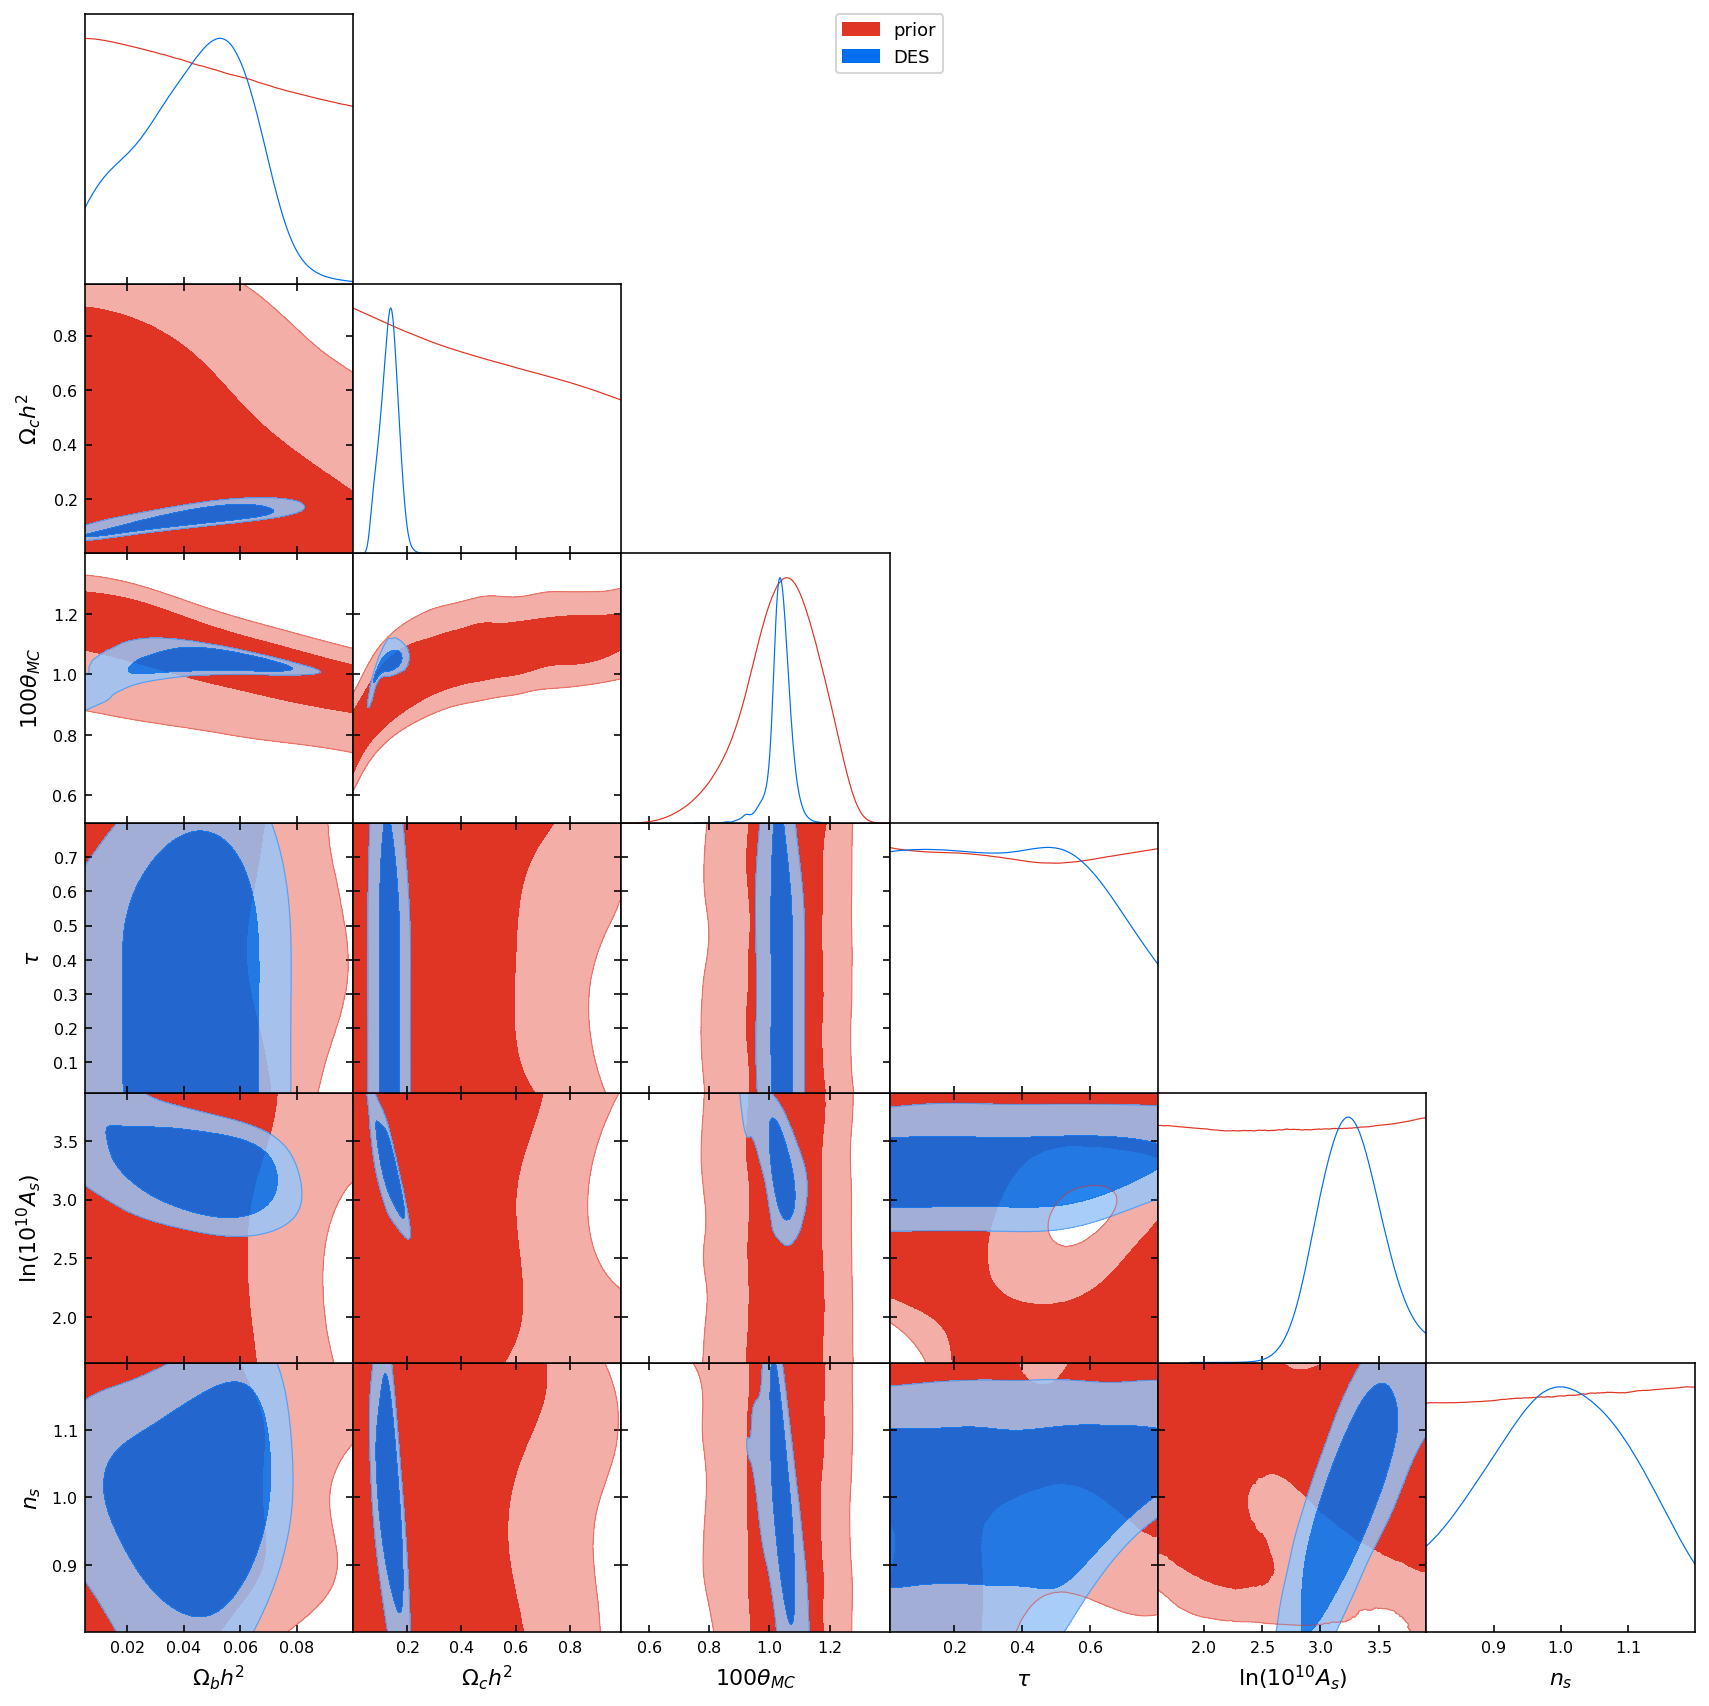

In [3]:
param_names = chain.getParamNames().getRunningNames()
g = plots.get_subplot_plotter()
g.triangle_plot([prior_chain, chain], params=param_names, filled=True)

This plot is not particularly illuminating. We might guess that 4 parameteres are constrained but it is hard to be sure about the number because of degeneracies.

## How many parameters are constrained?

To quantify how many parameters DES is measuring over the prior we compute the number of constrained parameters, as discussed in (https://arxiv.org/pdf/1806.04649.pdf).

The posterior covariance, $C_p$, combines the prior, $C_\Pi$, and data, $C$, covariances as:
\begin{align}
C_p^{-1} = C_\Pi^{-1} + C^{-1}
\end{align}
A parameter is measured when the posterior is closest to the purely data covariance $C^{-1}C_p \sim I$ (i.e. the prior is irrelevant). 

With a little algebra the number of parameters that are constrained by the data over the prior is:
\begin{align}
N_{\rm eff} \equiv N -{\rm Tr}(C_\Pi^{-1} C_p)
\end{align}
where $N$ is the nominal number of parameters.

This tells us how many parameters the data set is measuring. Notice that one important property is that this quantity is reparametrization invariant so it does not really depend on the specific parameters that we are using.

In [4]:
gaussian_tension.get_Neff(chain, param_names=param_names, prior_chain=prior_chain)

3.3147726236832553

This tells us that DES is measuging three cosmological parameters that we now try to nail down.

Since the number of constrained parameters is reparametrization invariant we first use some of our physical intuition to change to a more suitable parameter basis and neglect $\tau$.

In [5]:
param_names = ['omegam', 'omegab', 'sigma8', 'ns', 'H0']

We can plot these parameters:

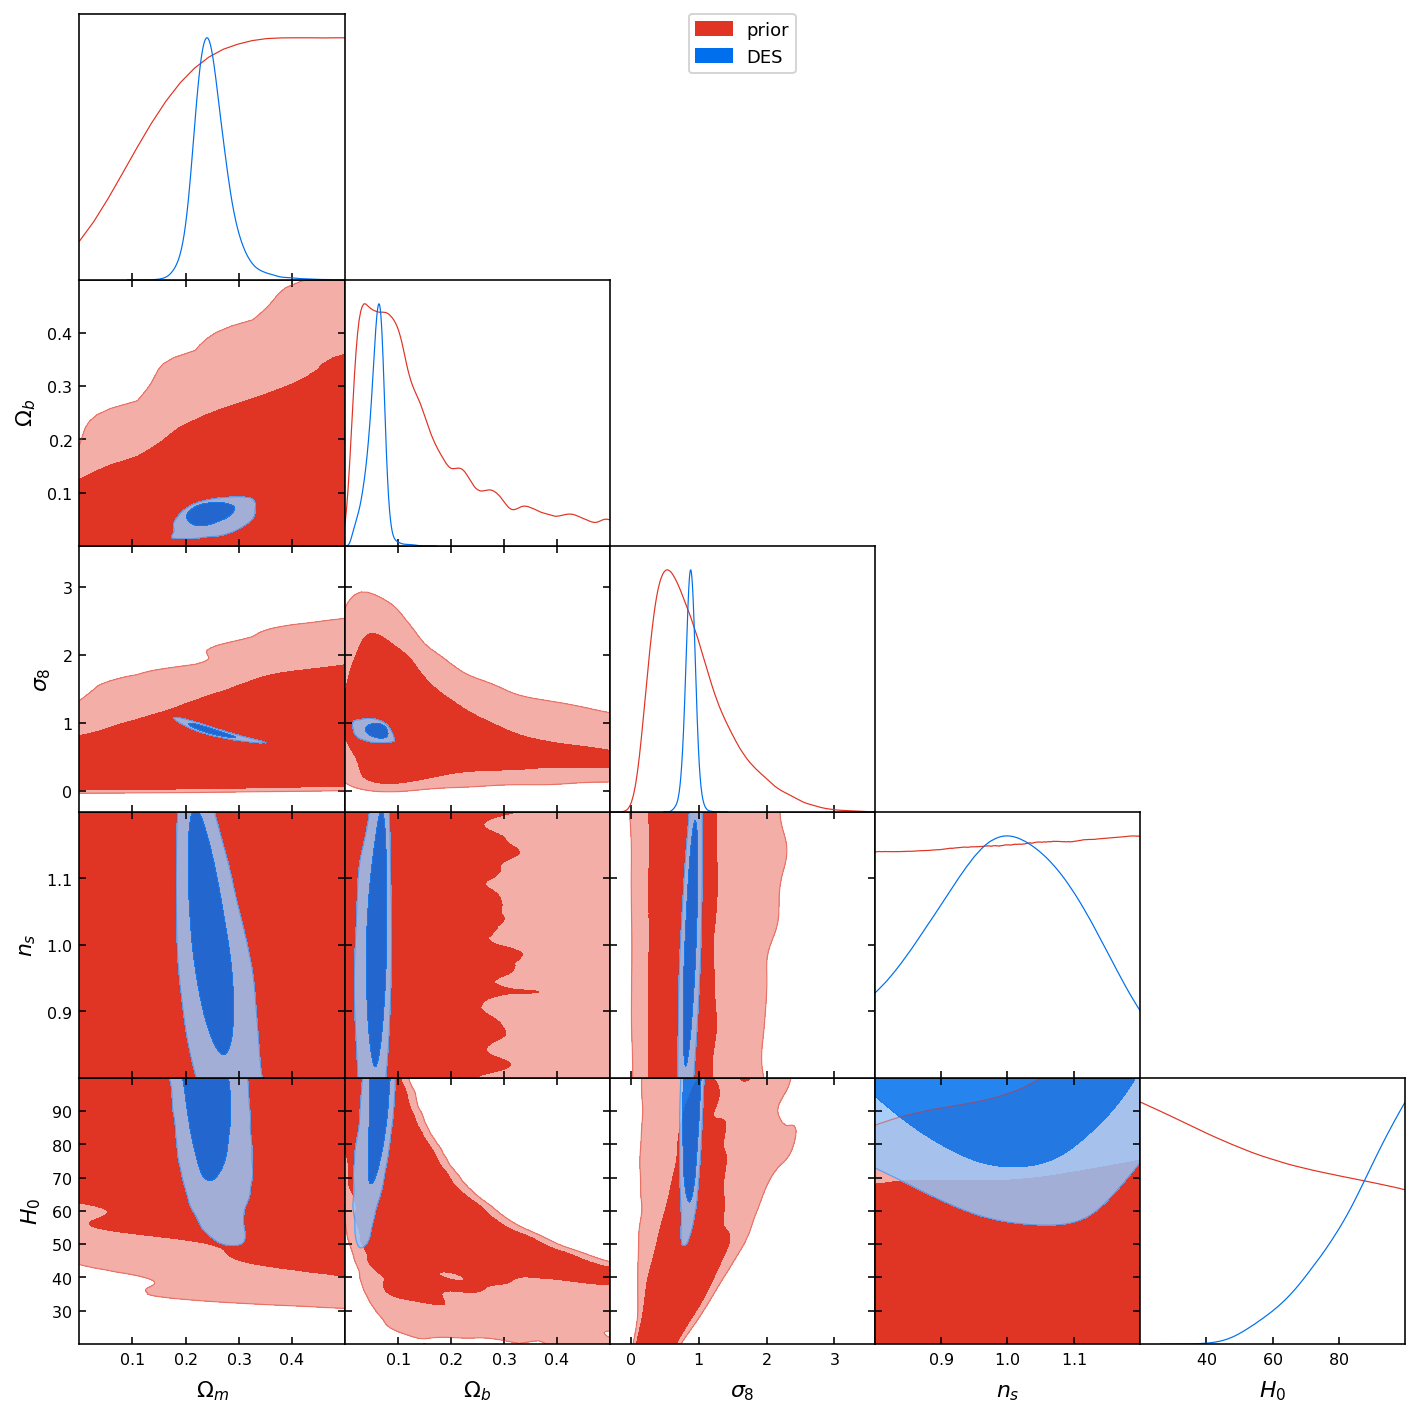

In [6]:
param_limits = {'omegam':[0.,.5], 'omegab':[0.,.5]}
g = plots.get_subplot_plotter()
g.triangle_plot([prior_chain,chain], params=param_names, filled=True, param_limits=param_limits)

This gives us a picture that is closer to our expectation of three+ constrained parameters and we can verify that by recomputing the number of constrained parameters in this parameter basis:

In [7]:
gaussian_tension.get_Neff(chain, param_names=param_names, prior_chain=prior_chain)

3.5927990946746253

As we can see we have all the parameters that we need. 
This number is sliglthy larger than the previous result because of clear non-Gaussianities.

## Constrained parameters combinations:

The parameters that we have here are degenerate and we want to disentangle them to better understand their physical meaning.

Since our measurements are mostly multiplicative when building the power spectra we consider the logarithm of these parameters to perform a power law decomposition:

In [8]:
for ch in [chain, prior_chain]:
    p = ch.getParams()
    ch.addDerived(np.log(p.omegam), name='log_omegam', label='\\log \\Omega_m')
    ch.addDerived(np.log(p.omegab), name='log_omegab', label='\\log \\Omega_b')
    ch.addDerived(np.log(p.sigma8), name='log_sigma8', label='\\log \\sigma_8')
    ch.addDerived(np.log(p.ns), name='log_ns', label='\\log n_s')
    ch.addDerived(np.log(p.H0), name='log_H0', label='\\log H_0')

We now want to compute the parameter space combinations for which the posterior is an improvement of the prior, i.e. $C_\Pi - C_p > 0$.

To do this we compute the KL decomposition of the posterior covariance with respect to the prior covariance, as discussed in (https://arxiv.org/pdf/1806.04649.pdf).
We solve the generalized eigenvalue problem:
\begin{align}
C_{\Pi} \phi_i = \lambda_i C_p \phi_i
\end{align}
and refer to $\phi_i$ as KL modes and $\lambda_i$ as its eigenvalues.
KL modes are not orthonormal with respect to the Euclidean metric, as in Principal Component Analysis (PCA), but are orthogonal with respect to the metric induced by $C_p$ and $C_\Pi$:
\begin{align}
\phi_i C_p \phi_i =& \delta_{ij} \\
\phi_i C_{\Pi} \phi_i =& \lambda_i \delta_{ij} \\
\end{align}

Although these directions are expressed in the given parameter basis they are reparametrization invariant.
Notice that this is not true for PCA even if we were to apply it to the correlation matrix.
$\lambda_i$ is the improvement factor of the posterior with respect to the prior for the $i$-th KL mode.

A couple of useful properties. If we denote with $\Phi$ the matrix of KL modes and $\Lambda$ the diagonal matrix with KL eigenvalues, then we have these two useful identities:
\begin{align}
C_\Pi^{-1} =& \Phi \Lambda^{-1} \Phi^T \\
C_p^{-1} =& \Phi \Phi^T \\
C^{-1} =& \Phi (I -\Lambda^{-1}) \Phi^T
\end{align}

We now look at the improvement over the prior:

In [9]:
# do the KL decomposition on the log parameters:
KL_param_names = ['log_'+name for name in param_names]
# compute the KL modes:
KL_eig, KL_eigv, KL_param_names = gaussian_tension.Q_UDM_KL_components(prior_chain, chain, param_names=KL_param_names)
# print:
with np.printoptions(precision=2, suppress=True):
    print('Improvement factor over the prior:', KL_eig)
    print('Improvement in error units:', np.sqrt(KL_eig-1))

Improvement factor over the prior: [1419.15   51.34   31.38    1.34    1.11]
Improvement in error units: [37.66  7.1   5.51  0.58  0.34]


As we can see we have three parameters whose error bar is improved over the prior by more than a factor of two. 
Other modes show an improvement in errorbar that is smaller than 50%.

We now want to plot the projection of these modes over parameters to see what parameter is contributing the most (in units of its variance).
To do so we decompose the parameter Fisher matrix over KL components. In the following figure rows sum to one and tell us how much a given KL mode contributes to the error bar (not marginalized) of the given parameter.

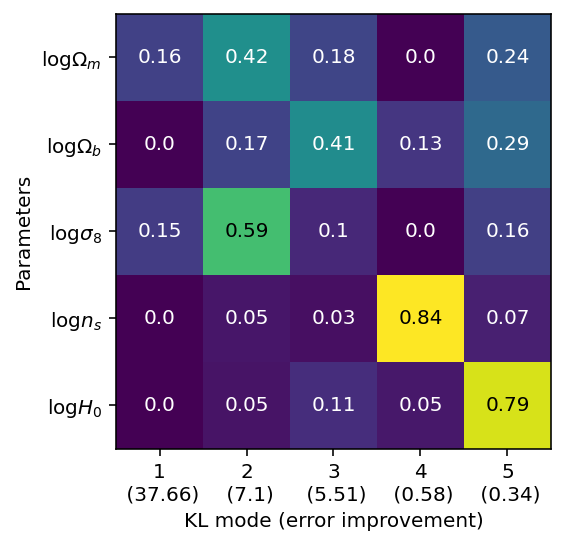

In [10]:
# First we compute the fractional Fisher matrix:
KL_param_names, KL_eig, fractional_fisher = gaussian_tension.Q_UDM_fisher_components(prior_chain, chain, KL_param_names, which='1')
# plot (showing values and names):
im1 = plt.imshow( fractional_fisher, cmap='viridis')
num_params = len(fractional_fisher)
for i in range(num_params):
    for j in range(num_params):
        if fractional_fisher[j,i]>0.5:
            col = 'k'
        else:
            col = 'w'
        plt.text(i, j, np.round(fractional_fisher[j,i],2), va='center', ha='center', color=col)
plt.xlabel('KL mode (error improvement)');
plt.ylabel('Parameters');
ticks  = np.arange(num_params)
labels = [ str(t+1)+'\n ('+str(l)+')' for t,l in zip(ticks,np.round(np.sqrt(KL_eig-1.),2))]
plt.xticks(ticks, labels, horizontalalignment='center');
labels = [ '$'+chain.getParamNames().parWithName(name).label+'$' for name in KL_param_names ]
plt.yticks(ticks, labels, horizontalalignment='right');

As we can see the first two, best constrained, modes almost entirely inform $\Omega_m$ and $\sigma_8$.
The third mode is almost entirely projecting on $\Omega_b$.
The last two weak modes are projecting on $n_s$ and $H_0$.

We can now visualize the modes in parameter space:

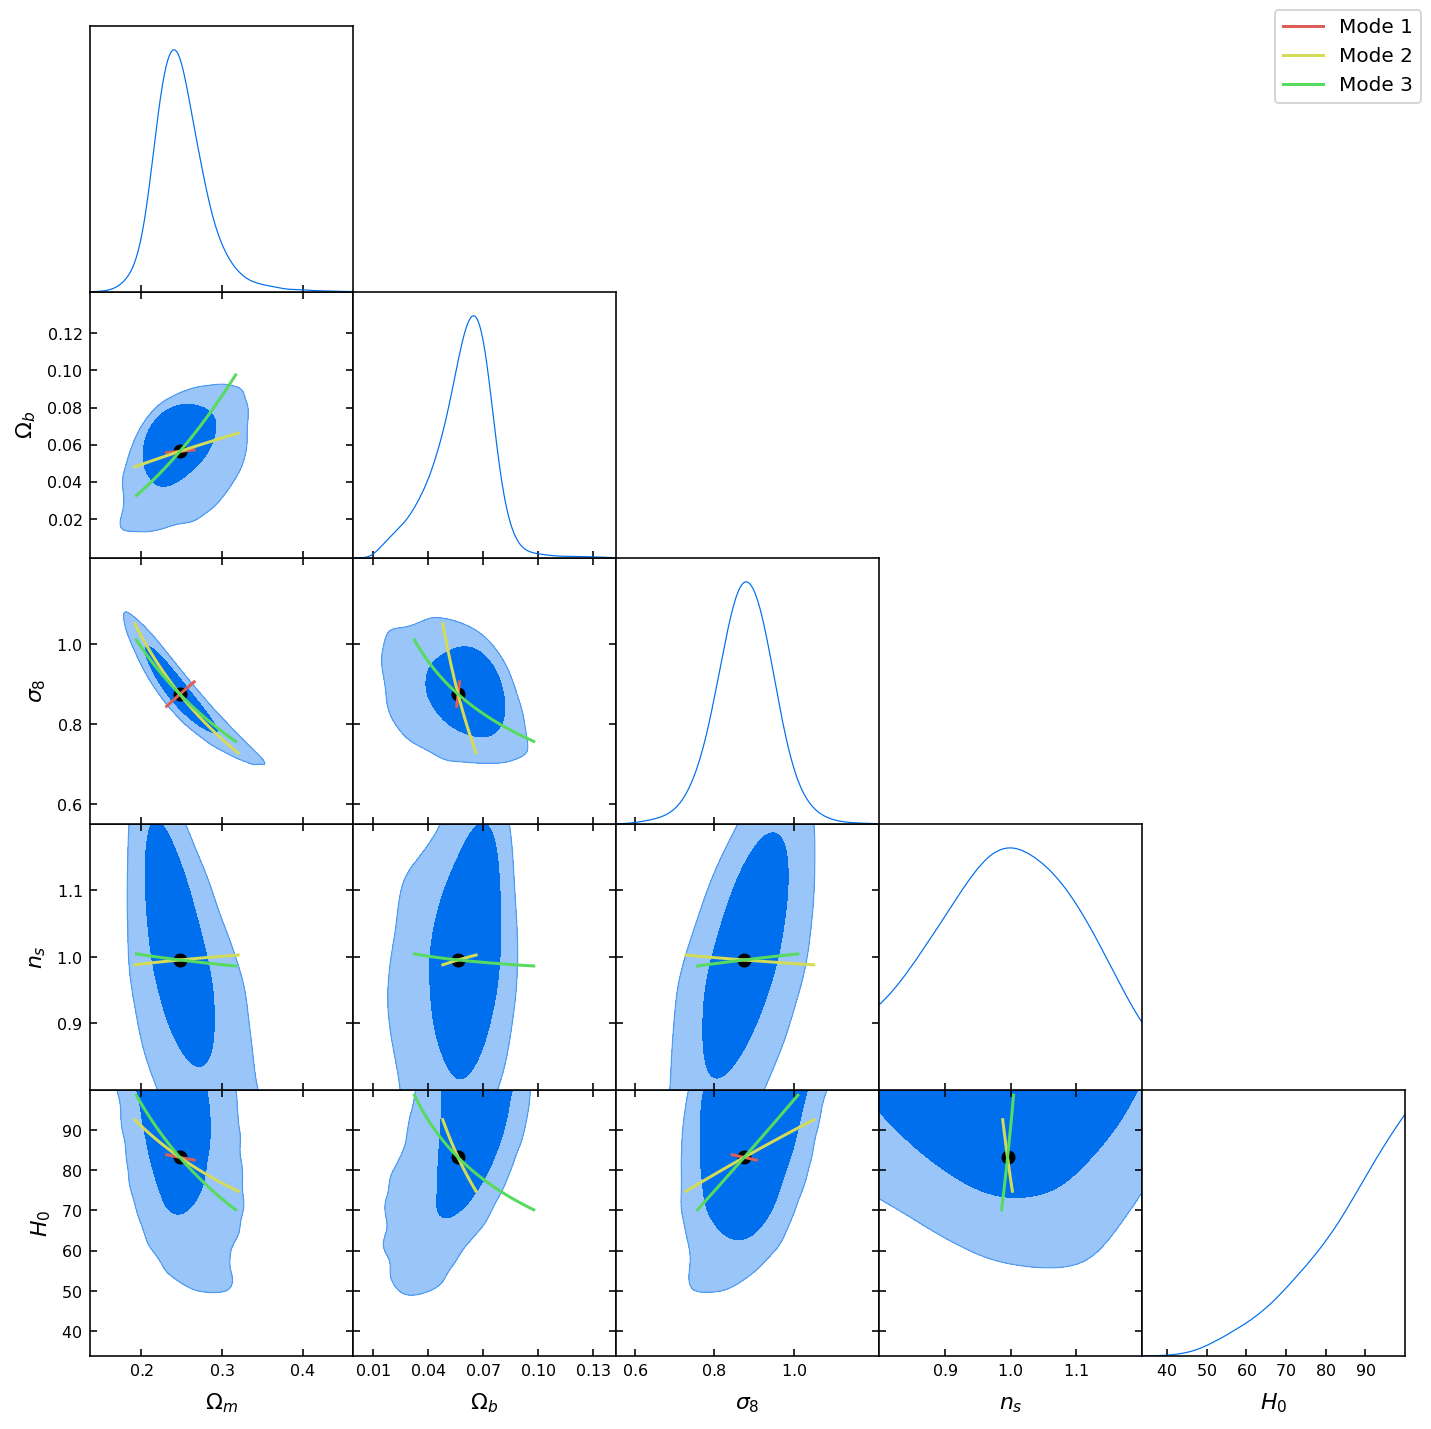

In [11]:
# compute the parameter space combinations corresponding to KL modes:
param_directions = np.linalg.inv(KL_eigv.T)
g = plots.get_subplot_plotter()
g.triangle_plot([chain], params=param_names, filled=True)
# add the modes:
for i in range(len(param_names)-1):
    for j in range(i+1,len(param_names)):
        ax = g.subplots[j,i]
        # get mean:
        m1, m2 = chain.getMeans(pars=[chain.index[name]
                       for name in [KL_param_names[i], KL_param_names[j]]])
        ax.scatter(np.exp(m1), np.exp(m2), color='k')
        alpha = 3.*np.linspace(-1.,1.,100)
        for k in range(3):
            ax.plot(np.exp(m1+alpha*param_directions[:,k][i]), np.exp(m2+alpha*param_directions[:,k][j]), color=sns.hls_palette(6)[k], label='Mode '+str(k+1))
g.fig.legend(*ax.get_legend_handles_labels());    

We can project the posterior on the KL modes. In this space the posterior parameters are going to be uncorrelated and with unit variance.

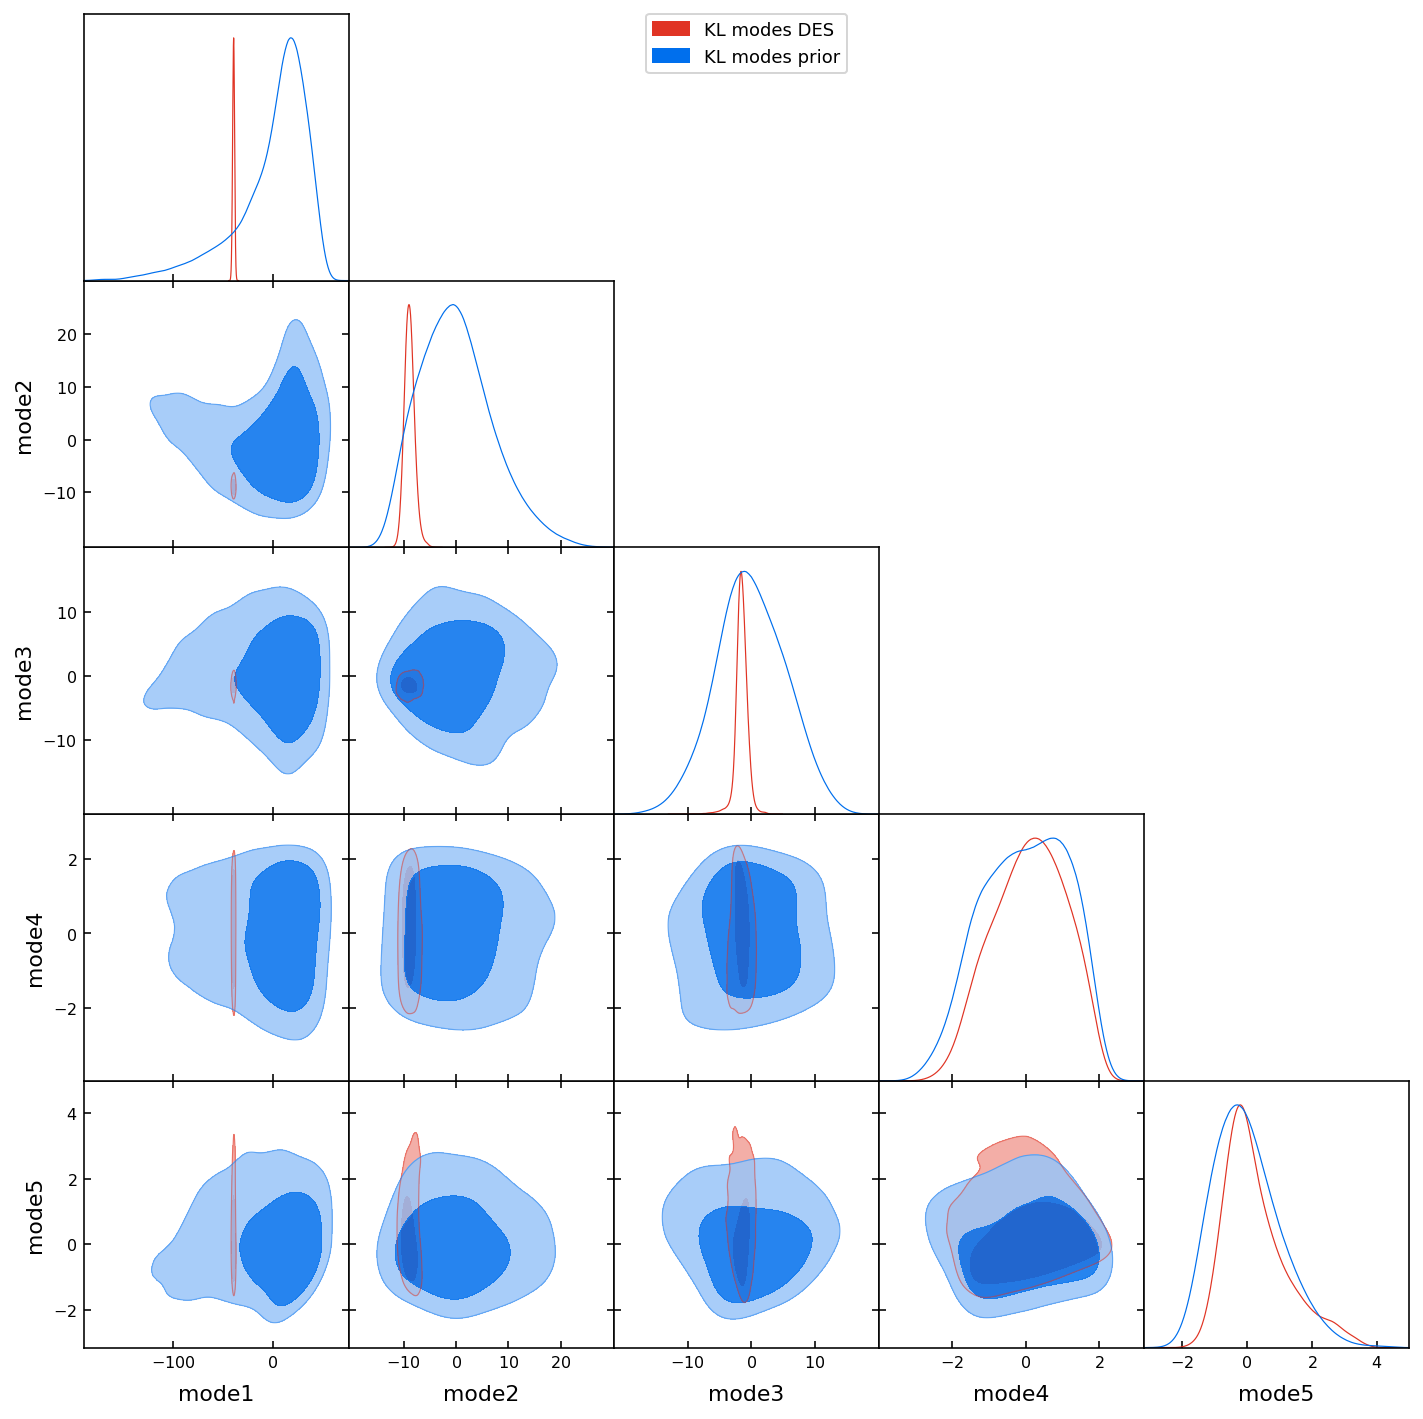

In [12]:
idx = [chain.index[name] for name in KL_param_names]
prior_mean = prior_chain.getMeans(pars=[prior_chain.index[name] for name in KL_param_names])
temp_names = ['mode'+str(i+1) for i in range(len(KL_param_names))]
KL_filtered_samples = np.dot(chain.samples[:,idx]-prior_mean, KL_eigv)
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=chain.loglikes, 
                     weights=chain.weights, 
                     names=temp_names, 
                     label='KL modes DES')
idx = [prior_chain.index[name] for name in KL_param_names]
KL_filtered_prior_samples = np.dot(prior_chain.samples[:,idx]-prior_mean, KL_eigv)
KL_prior_chain = MCSamples(samples=KL_filtered_prior_samples, 
                     loglikes=prior_chain.loglikes, 
                     weights=prior_chain.weights, 
                     names=temp_names, 
                     label='KL modes prior')
g = plots.get_subplot_plotter()
g.triangle_plot([KL_chain,KL_prior_chain], params=temp_names, filled=True)

Note that the first few modes are well constrained and their posterior is fairly Gaussian, as data constraint over prior degrades non-Gaussianities arise.

Since we are considering the logarithm of parameters our KL decomposition corresponds to a power law decomposition.
We now reconstruct the representation of the best constrained mode in the original parameter space. 

In [13]:
print(param_names)
with np.printoptions(precision=3, suppress=True):
    print('Mean: ', np.exp(chain.getMeans(pars=[chain.index[name] for name in KL_param_names])))
    print('Mode 1, exponent:', KL_eigv.T[0,:]/KL_eigv.T[0,param_names.index('sigma8')])
    print('Mode 2, exponent:', KL_eigv.T[1,:]/KL_eigv.T[1,param_names.index('sigma8')])
    print('Mode 3, exponent:', KL_eigv.T[2,:]/KL_eigv.T[2,param_names.index('omegab')])

['omegam', 'omegab', 'sigma8', 'ns', 'H0']
Mean:  [ 0.248  0.056  0.875  0.995 83.213]
Mode 1, exponent: [ 0.791 -0.06   1.     0.098  0.099]
Mode 2, exponent: [-0.638  0.337  1.    -1.088 -0.626]
Mode 3, exponent: [-0.794  1.     0.777 -1.682 -1.85 ]


In this power law decomposition the sensitivity to parameters is not built in. As an example the exponential of $n_s$ is large but the effect on the parameters (see the above triangle plot) is very limited.

An aproximation for the best constrained parameter basis could be given:
\begin{align}
p_1 =& \sigma_8 \Omega_m^{0.7} \\
p_2 =& \sigma_8 \Omega_m^{-1/2} \\
p_3 =& \Omega_b \Omega_m^{-1/2}
\end{align}

This parameter basis should single out the most constrained parameter space directions over the priors and as such should be less sensitive to volume effects in $\Lambda$CDM.

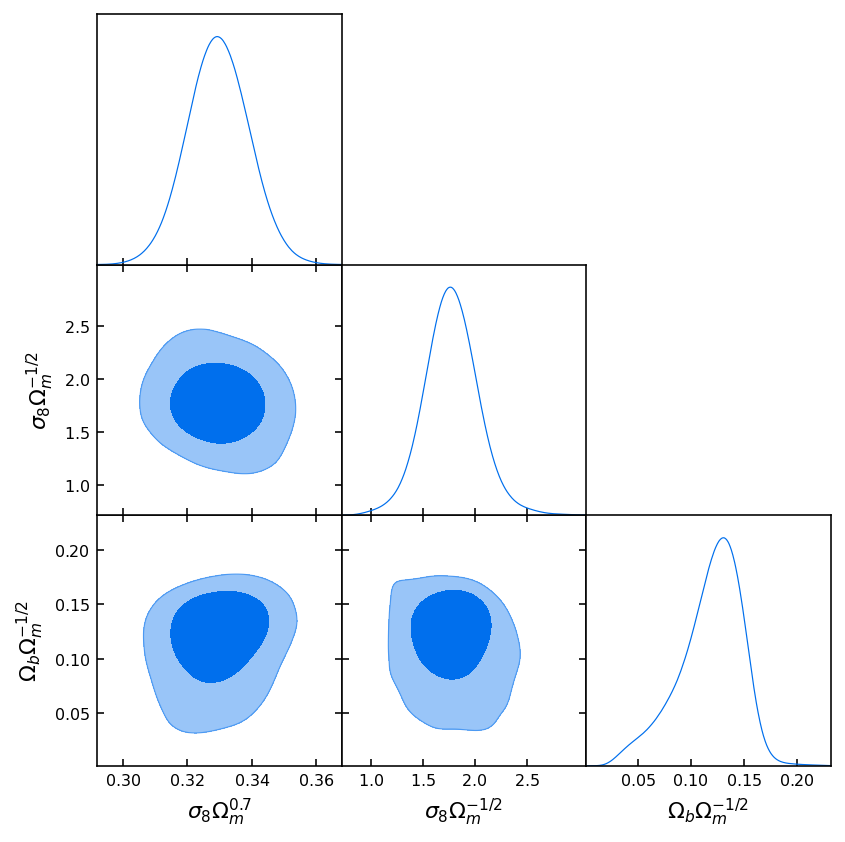

In [14]:
temp_chain = chain.copy()
p = temp_chain.getParams()
temp_chain.addDerived(p.sigma8*p.omegam**0.7, name='p1', label='\\sigma_8 \\Omega_m^{0.7}');
temp_chain.addDerived(p.sigma8*p.omegam**(-0.5), name='p2', label='\\sigma_8 \\Omega_m^{-1/2}');
temp_chain.addDerived(p.omegab*p.omegam**(-0.5), name='p3', label='\\Omega_b \\Omega_m^{-1/2}');
g = plots.get_subplot_plotter()
g.triangle_plot([temp_chain], params=['p1', 'p2', 'p3'], filled=True)

## Physics of constrained parameters combinations:

We next ask what is the physical meaning of these parameters. To do so we perform variations along the KL components and look at the matter power spectrum and other physical observables:

In [15]:
# first import camb
import camb
from camb import model
from camb.sources import GaussianSourceWindow
# then define helper to go from chains to camb parameters:
def camb_helper(chain, params):
    # parameters that we use:
    omegam, omegab, sigma8, ns, H0 = params
    # parameters that we fix:
    tau = 0.079
    h = H0/100.
    reference_As = 1.e-10*np.exp(chain.getMeans(pars=[chain.index['logA']]))
    # run CAMB once to get reference sigma 8:
    pars = camb.set_params(As = reference_As,
                           ns = ns,
                           H0 = H0,
                           ombh2 = omegab*h**2,
                           omch2 = (omegam-omegab)*h**2,
                           mnu = 0.06,
                           tau = tau,
                           redshifts=[0.],
                           kmax=10.0)
    results = camb.get_results(pars)
    # compute sigma 8:
    reference_sigma_8 = results.get_sigma8_0()
    # get the reference parameters:
    pars = camb.set_params(As = reference_As/reference_sigma_8**2*sigma8**2,
                       ns = ns,
                       H0 = H0,
                       ombh2 = omegab*h**2,
                       omch2 = (omegam-omegab)*h**2,
                       mnu = 0.06,
                       tau = tau,
                       redshifts=[0.],
                       kmax=10.0)
    # other settings:
    pars.NonLinear = model.NonLinear_none
    pars.NonLinear = model.NonLinear_both
    #
    return pars

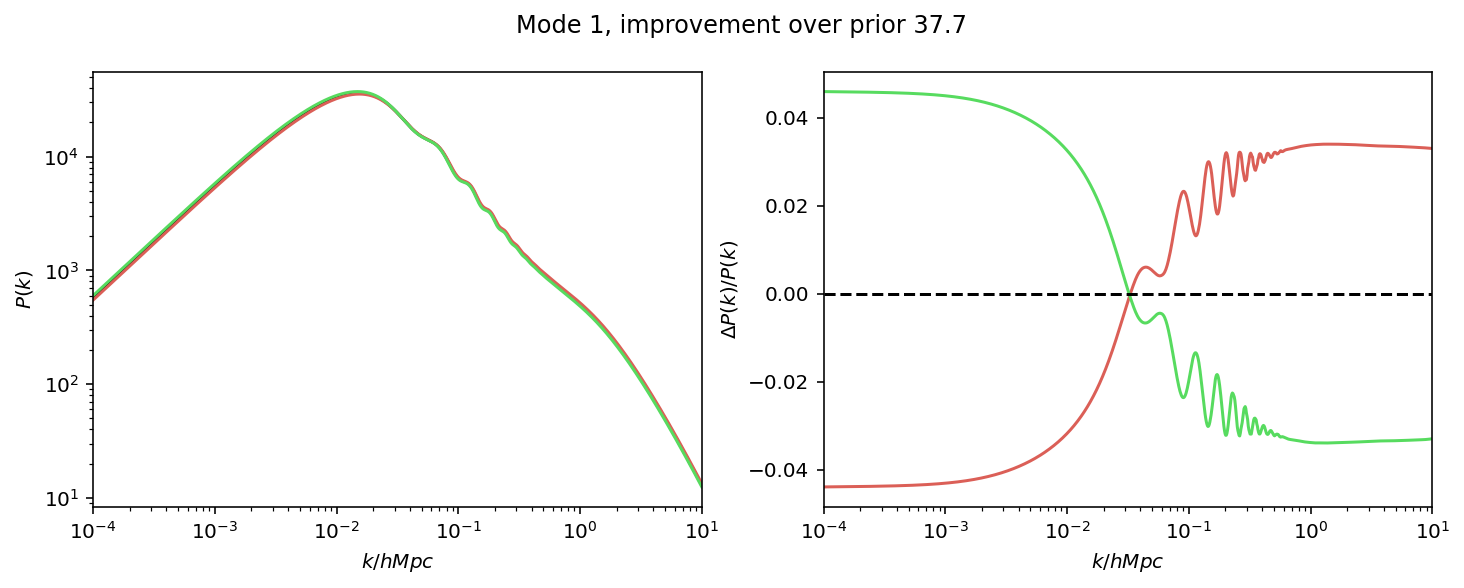

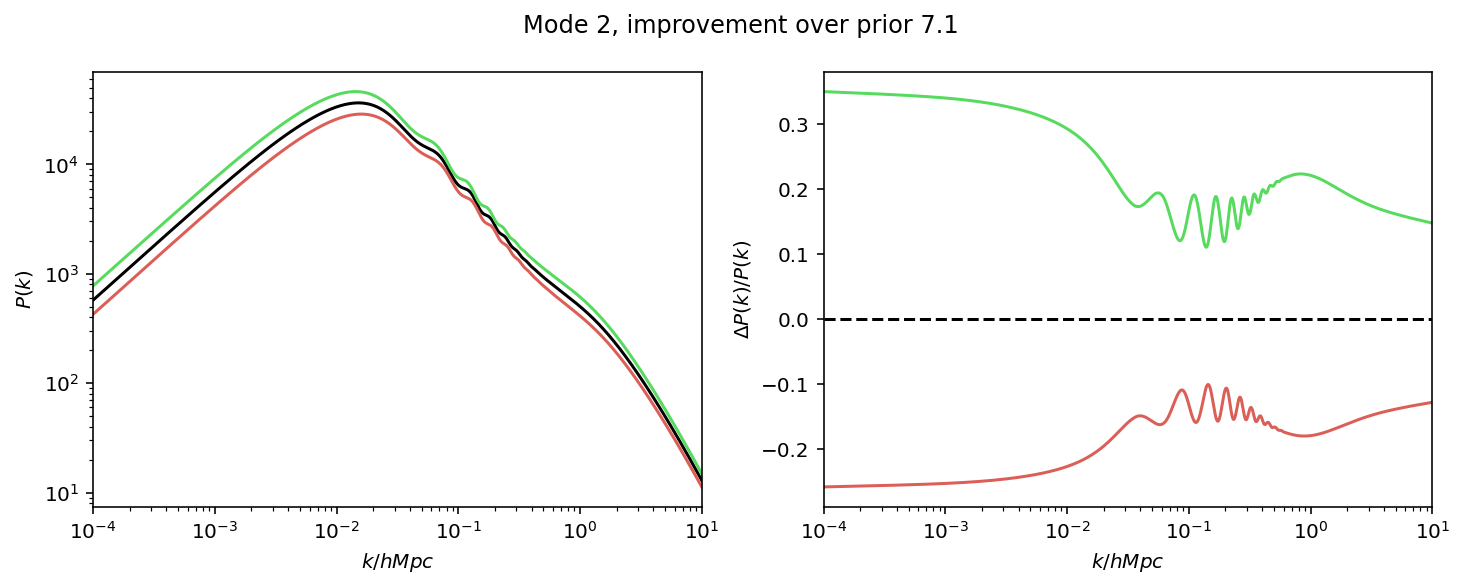

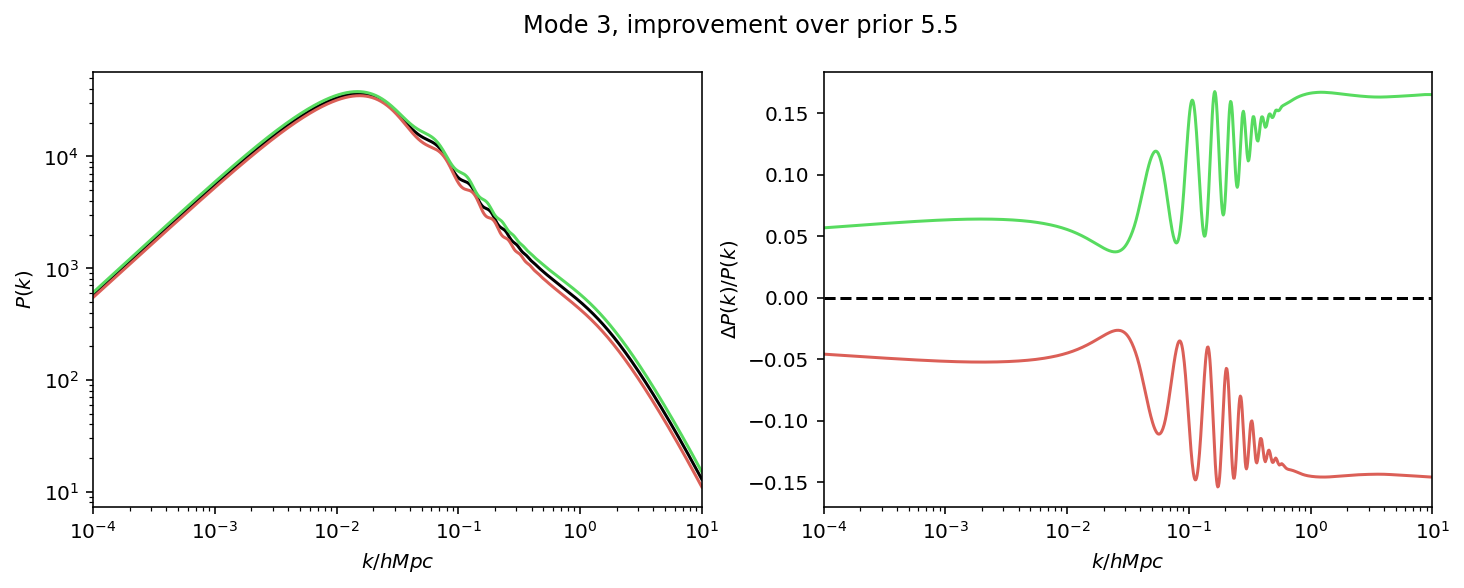

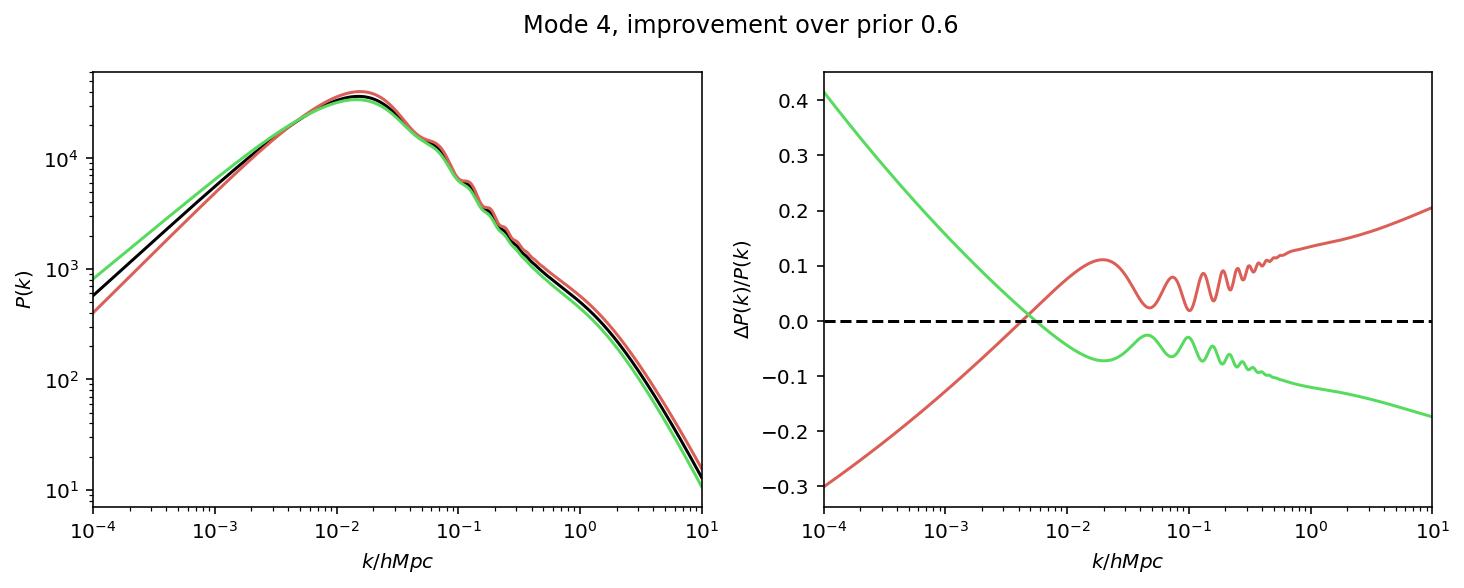

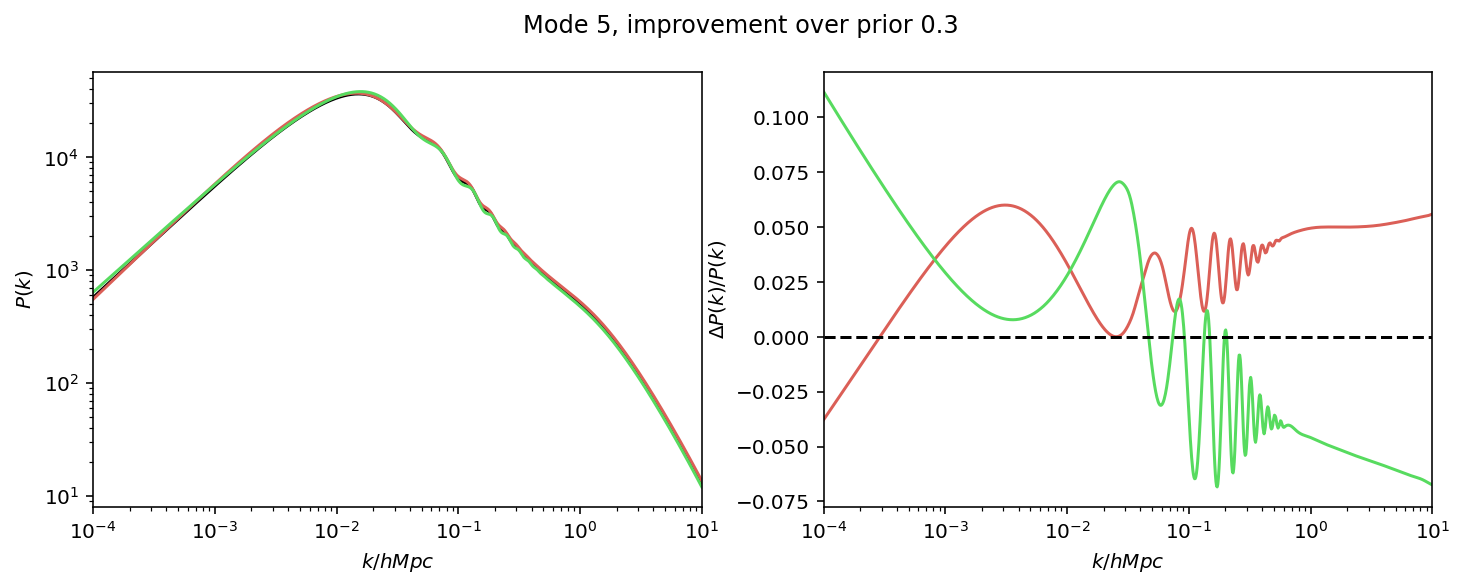

In [16]:
# compute mean cosmology:
mean_params = chain.getMeans(pars=[chain.index[name] for name in KL_param_names])
mean_camb_pars = camb_helper(chain, np.exp(mean_params))
mean_results = camb.get_results(mean_camb_pars)
kh, z, pk_ref = mean_results.get_matter_power_spectrum(minkh=1e-4, maxkh=10., npoints = 1000)
# now do parameter variations along the KL modes of the posterior with respect to the prior:
for ind in range(len(param_names)):
    # do a 2 sigma variation to see effects in the plots:
    camb_pars_plus = camb_helper(chain, np.exp(mean_params +1.*param_directions[:,ind]))
    camb_pars_minus = camb_helper(chain, np.exp(mean_params -1.*param_directions[:,ind]))
    # compute camb power spectra:
    results_plus = camb.get_results(camb_pars_plus)
    results_minus = camb.get_results(camb_pars_minus)
    _, _, pk_plus = results_plus.get_matter_power_spectrum(minkh=1e-4, maxkh=10., npoints = 1000)
    _, _, pk_minus = results_minus.get_matter_power_spectrum(minkh=1e-4, maxkh=10., npoints = 1000)
    # plot:
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle('Mode '+str(ind+1)+', improvement over prior '+str(round(np.sqrt(KL_eig[ind]-1),1)))
    ax[0].plot(kh, pk_ref[0], color='k')
    ax[0].plot(kh, pk_plus[0], color=sns.hls_palette(6)[0])
    ax[0].plot(kh, pk_minus[0], color=sns.hls_palette(6)[2])
    ax[0].set_yscale('log')
    ax[0].set_ylabel('$P(k)$')
    ax[1].plot(kh, (pk_plus[0]-pk_ref[0])/pk_ref[0], color=sns.hls_palette(6)[0])
    ax[1].plot(kh, (pk_minus[0]-pk_ref[0])/pk_ref[0], color=sns.hls_palette(6)[2])
    ax[1].axhline(0., ls='--', color='k')
    ax[1].set_ylabel('$\\Delta P(k)/ P(k)$')
    for _ax in ax:
        _ax.set_xlabel('$k/h Mpc$')
        _ax.set_xscale('log')
        _ax.set_xlim([np.amin(kh), np.amax(kh)])

We now have to remember that we do not really observe the matter power spectrum. 

We can easily look at observable galaxy clustering and lensing power spectra to see what is happening.
This is closer to what our data set is constructed. 
We do not want to complicate this too much so we restrict to a toy example where we use two Gaussian redshift distributions to mimick the DES ones, centered at redshift $z=0.5$ and with width $\Delta z = 0.1$.

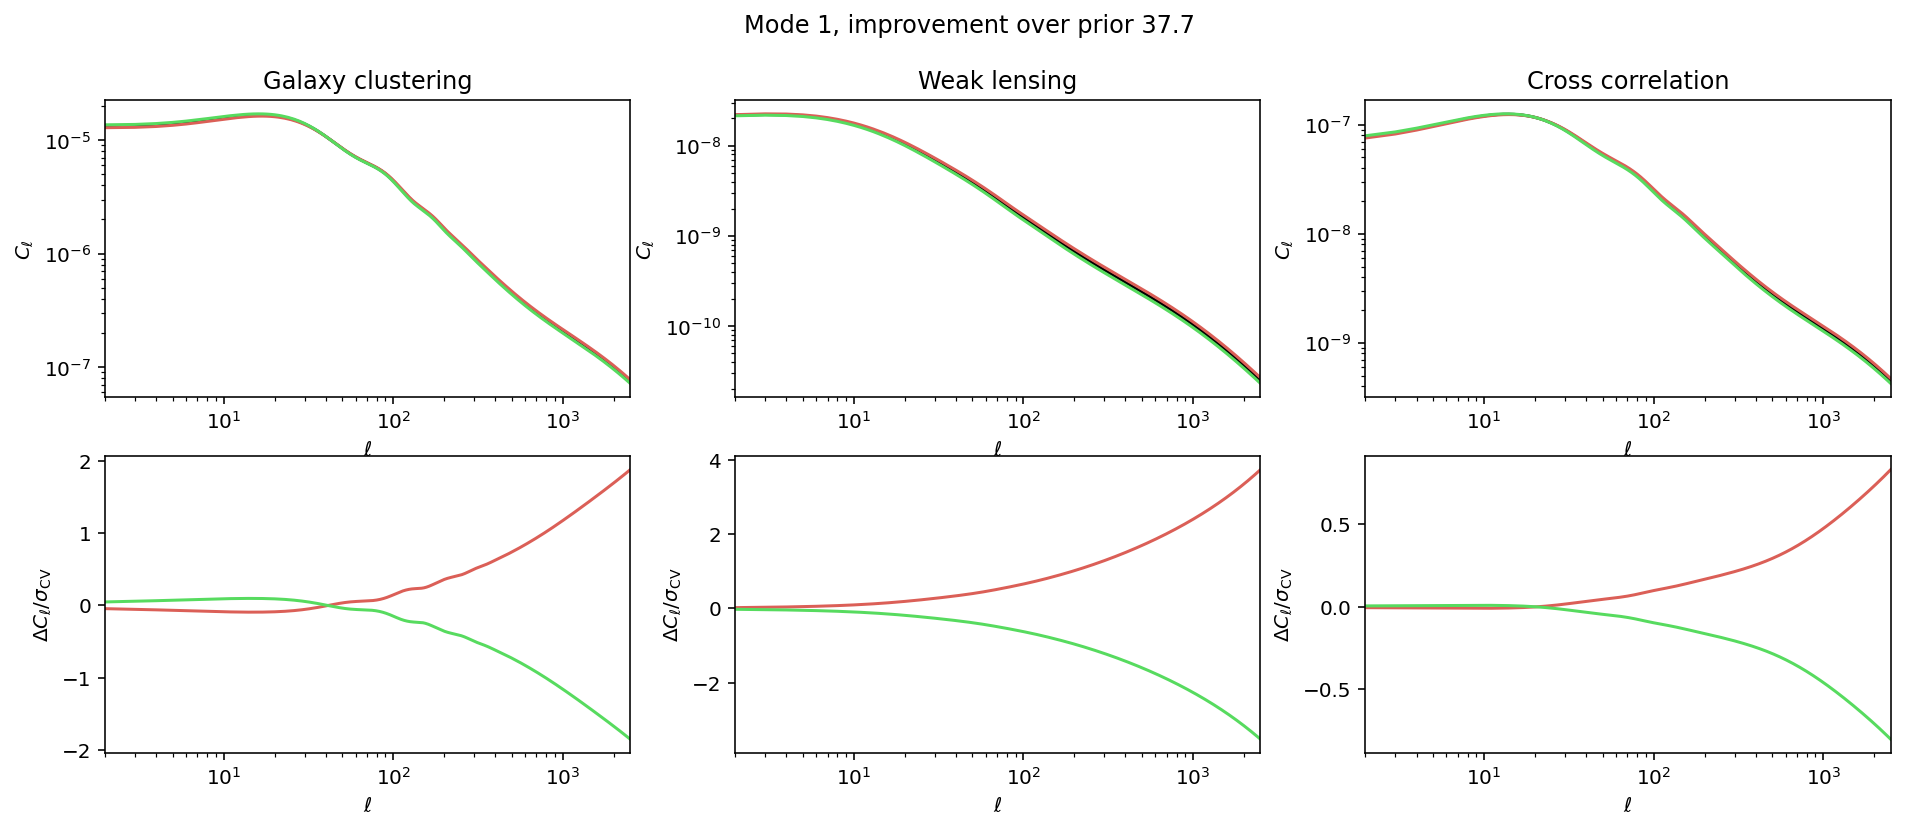

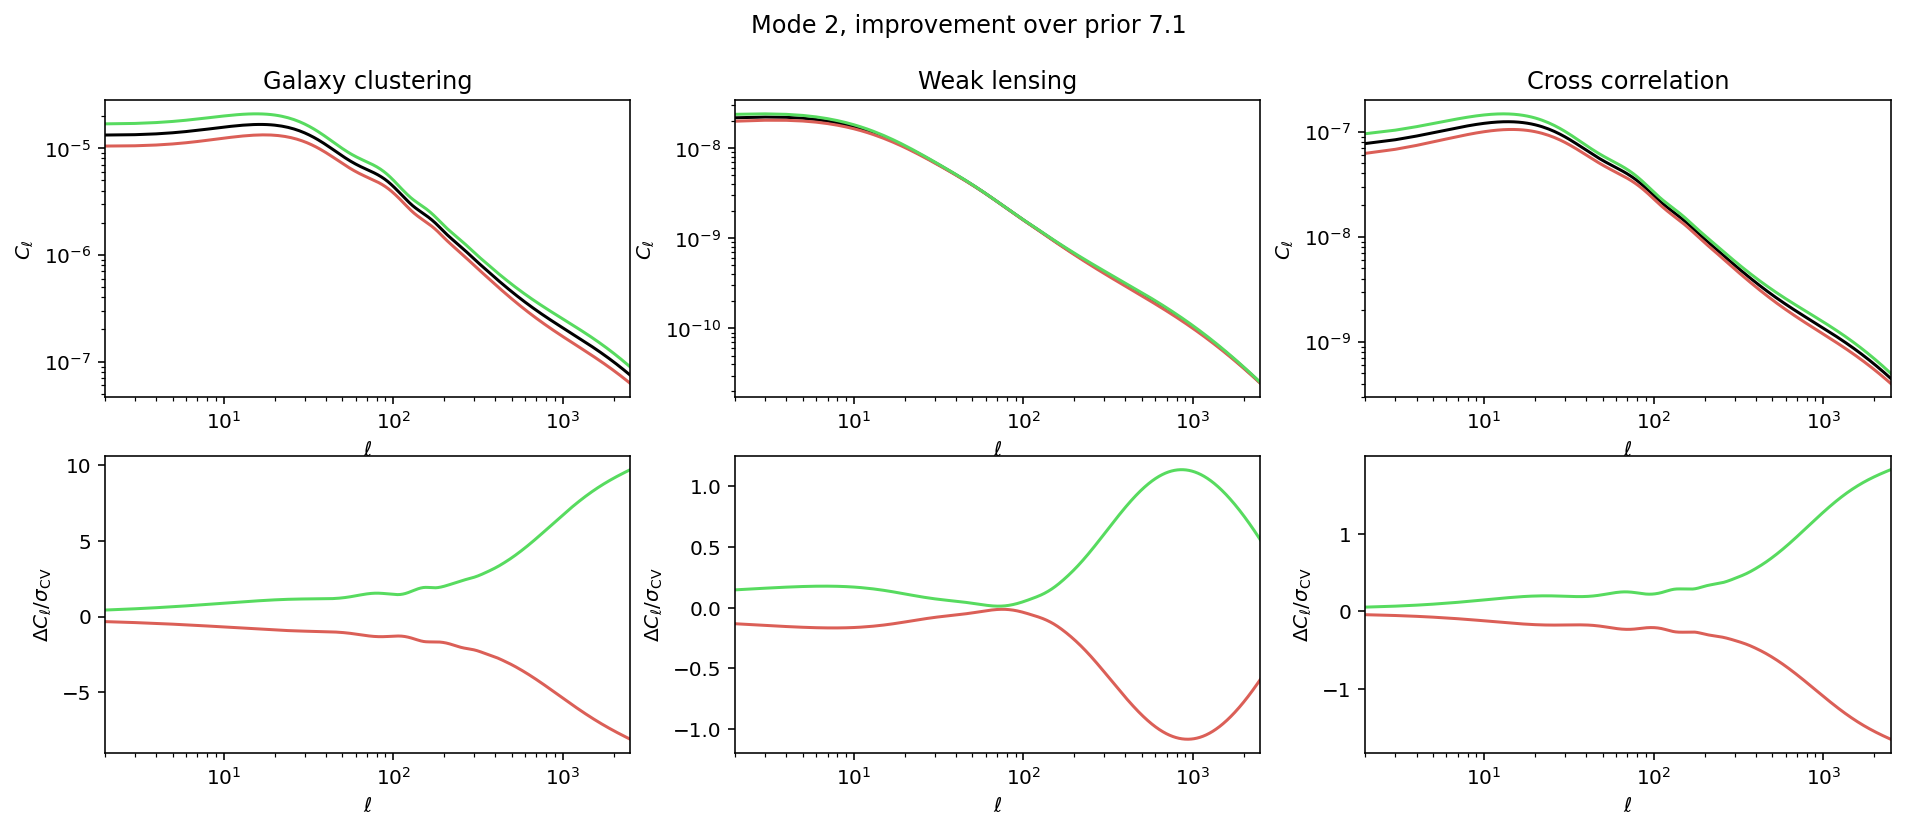

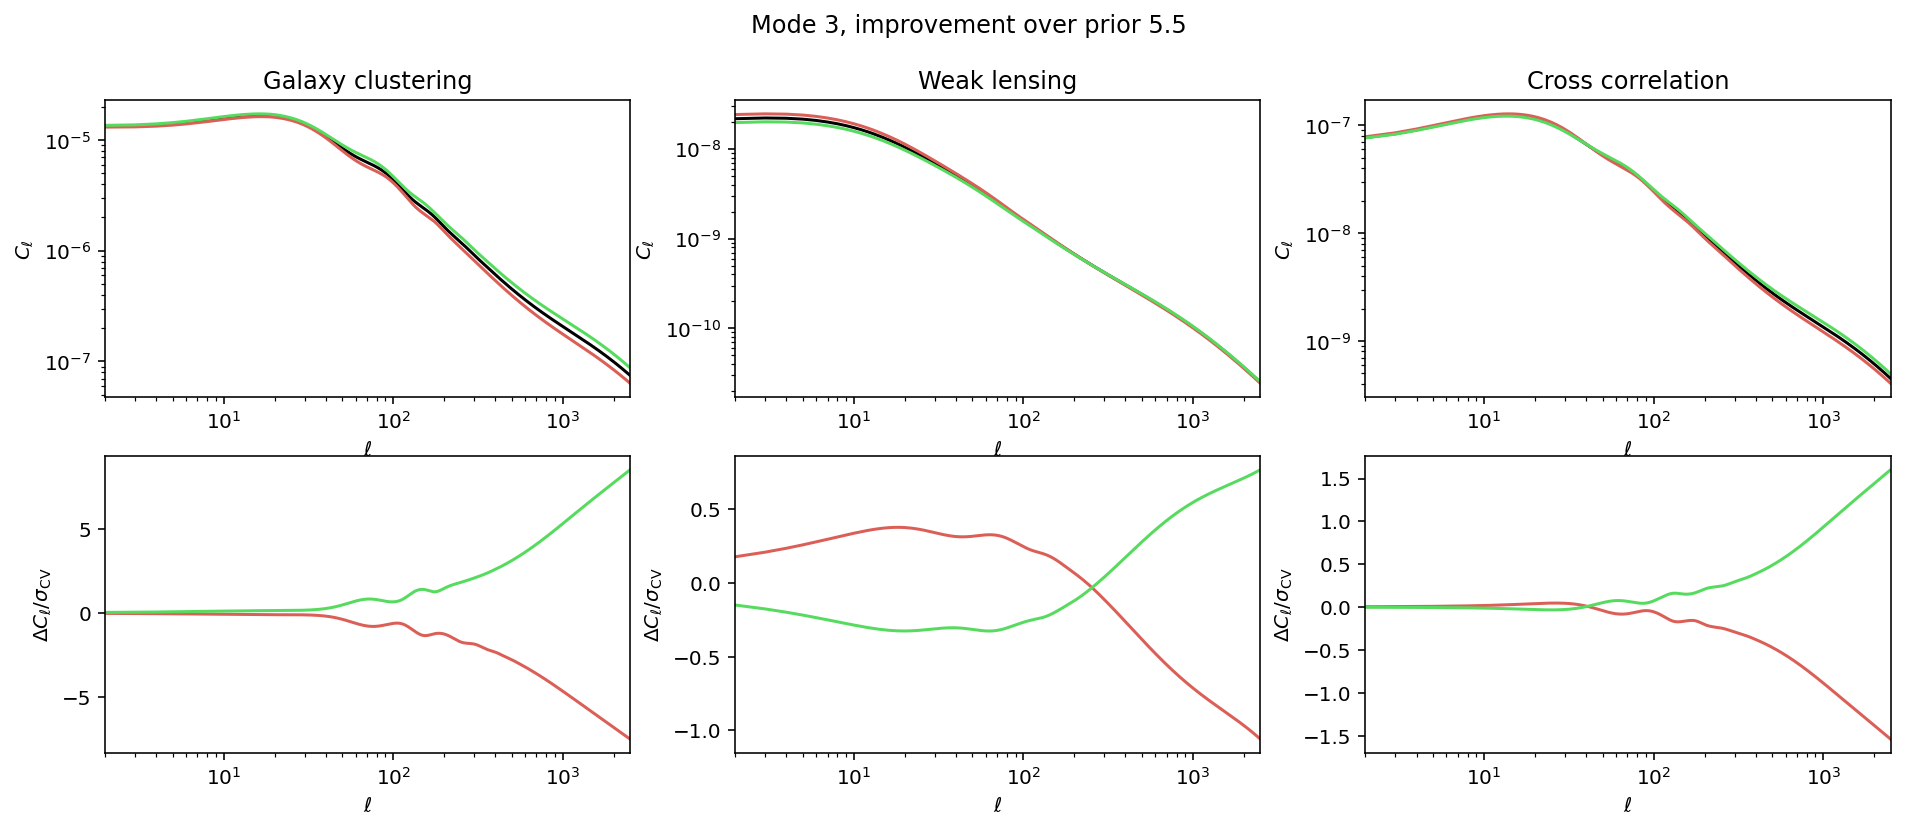

In [17]:
# compute mean cosmology:
mean_params = chain.getMeans(pars=[chain.index[name] for name in KL_param_names])
mean_camb_pars = camb_helper(chain, np.exp(mean_params))
mean_camb_pars.SourceWindows = [GaussianSourceWindow(redshift=0.5, source_type='counts' , sigma=0.1, bias=1., dlog10Ndm=0.),
                                GaussianSourceWindow(redshift=0.5, source_type='lensing', sigma=0.1)]
mean_results = camb.get_results(mean_camb_pars)
cls_ref = mean_results.get_source_cls_dict(raw_cl=True)
# now do parameter variations along the KL modes of the posterior with respect to the prior:
for ind in range(3):
    # do a 2 sigma variation to see effects in the plots:
    camb_pars_plus = camb_helper(chain, np.exp(mean_params +1.*param_directions[:,ind]))
    camb_pars_minus = camb_helper(chain, np.exp(mean_params -1.*param_directions[:,ind]))
    # add sources:
    for p in [camb_pars_plus,camb_pars_minus]:
        p.SourceWindows = [GaussianSourceWindow(redshift=0.5, source_type='counts' , sigma=0.1, bias=1., dlog10Ndm=0.),
                           GaussianSourceWindow(redshift=0.5, source_type='lensing', sigma=0.1)]
    # compute camb power spectra:
    results_plus = camb.get_results(camb_pars_plus)
    results_minus = camb.get_results(camb_pars_minus)
    cls_plus = results_plus.get_source_cls_dict(raw_cl=True)
    cls_minus = results_minus.get_source_cls_dict(raw_cl=True)
    ell = np.array(list(range(len((list(cls_ref.values())[0])))))
    cv_fac = np.sqrt(2/(2*ell+1))
    # plot:
    fig, ax = plt.subplots(2, 3, figsize = (16,6))
    fig.suptitle('Mode '+str(ind+1)+', improvement over prior '+str(round(np.sqrt(KL_eig[ind]-1),1)))
    ax[0,0].plot(ell[2:], cls_ref['W1xW1'][2:], color='k')
    ax[0,0].plot(ell[2:], cls_plus['W1xW1'][2:], color=sns.hls_palette(6)[0])
    ax[0,0].plot(ell[2:], cls_minus['W1xW1'][2:], color=sns.hls_palette(6)[2])
    ax[0,1].plot(ell[2:], cls_ref['W2xW2'][2:], color='k')
    ax[0,1].plot(ell[2:], cls_plus['W2xW2'][2:], color=sns.hls_palette(6)[0])
    ax[0,1].plot(ell[2:], cls_minus['W2xW2'][2:], color=sns.hls_palette(6)[2])
    ax[0,2].plot(ell[2:], cls_ref['W1xW2'][2:], color='k')
    ax[0,2].plot(ell[2:], cls_plus['W1xW2'][2:], color=sns.hls_palette(6)[0])
    ax[0,2].plot(ell[2:], cls_minus['W1xW2'][2:], color=sns.hls_palette(6)[2])
    for _ax in ax[0,:]:
        _ax.set_xscale('log')
        _ax.set_yscale('log')
        _ax.set_xlabel('$\\ell$')
        _ax.set_ylabel('$C_\\ell$')
        _ax.set_xlim([np.amin(ell[2:]), np.amax(ell[2:])])
    ax[0,0].set_title('Galaxy clustering')
    ax[0,1].set_title('Weak lensing')
    ax[0,2].set_title('Cross correlation')
    ax[1,0].plot(ell[2:], (cls_plus['W1xW1'][2:]-cls_ref['W1xW1'][2:])/cls_ref['W1xW1'][2:]/cv_fac[2:], color=sns.hls_palette(6)[0])
    ax[1,0].plot(ell[2:], (cls_minus['W1xW1'][2:]-cls_ref['W1xW1'][2:])/cls_ref['W1xW1'][2:]/cv_fac[2:], color=sns.hls_palette(6)[2])
    ax[1,1].plot(ell[2:], (cls_plus['W2xW2'][2:]-cls_ref['W2xW2'][2:])/cls_ref['W2xW2'][2:]/cv_fac[2:], color=sns.hls_palette(6)[0])
    ax[1,1].plot(ell[2:], (cls_minus['W2xW2'][2:]-cls_ref['W2xW2'][2:])/cls_ref['W2xW2'][2:]/cv_fac[2:], color=sns.hls_palette(6)[2])
    ax[1,2].plot(ell[2:], (cls_plus['W1xW2'][2:]-cls_ref['W1xW2'][2:])/np.sqrt(cls_ref['W1xW1'][2:]*cls_ref['W2xW2'][2:]+cls_ref['W1xW2'][2:]**2)/cv_fac[2:], color=sns.hls_palette(6)[0])
    ax[1,2].plot(ell[2:], (cls_minus['W1xW2'][2:]-cls_ref['W1xW2'][2:])/np.sqrt(cls_ref['W1xW1'][2:]*cls_ref['W2xW2'][2:]+cls_ref['W1xW2'][2:]**2)/cv_fac[2:], color=sns.hls_palette(6)[2])
    for _ax in ax[1,:]:
        _ax.set_xscale('log')
        _ax.set_xlabel('$\\ell$')
        _ax.set_ylabel('$\\Delta C_\\ell/ \\sigma_{\\rm CV}$')
        _ax.set_xlim([np.amin(ell[2:]), np.amax(ell[2:])])
    # clean up:
    del(camb_pars_plus, camb_pars_minus, results_plus, results_minus)

As we can see the first two modes are quantifying differences in large to small scales power while the third mode is constraining small scales power at fixed large scale power.

We next look at the time evolution of a small scale mode in these two models. 
We only do one sided differences to maintain the plot easy to read.

In [18]:
a = np.logspace(-7.,0., 1000)
z = 1./a-1.
k = [1.0]
mean_ev = mean_results.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])

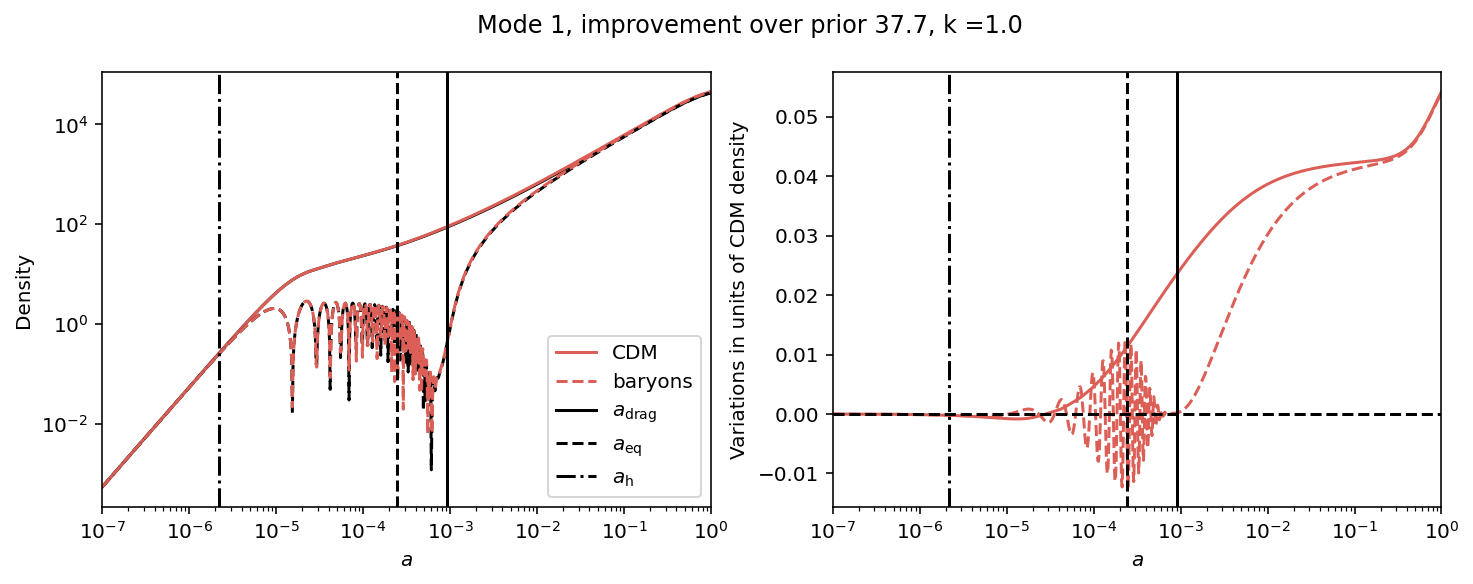

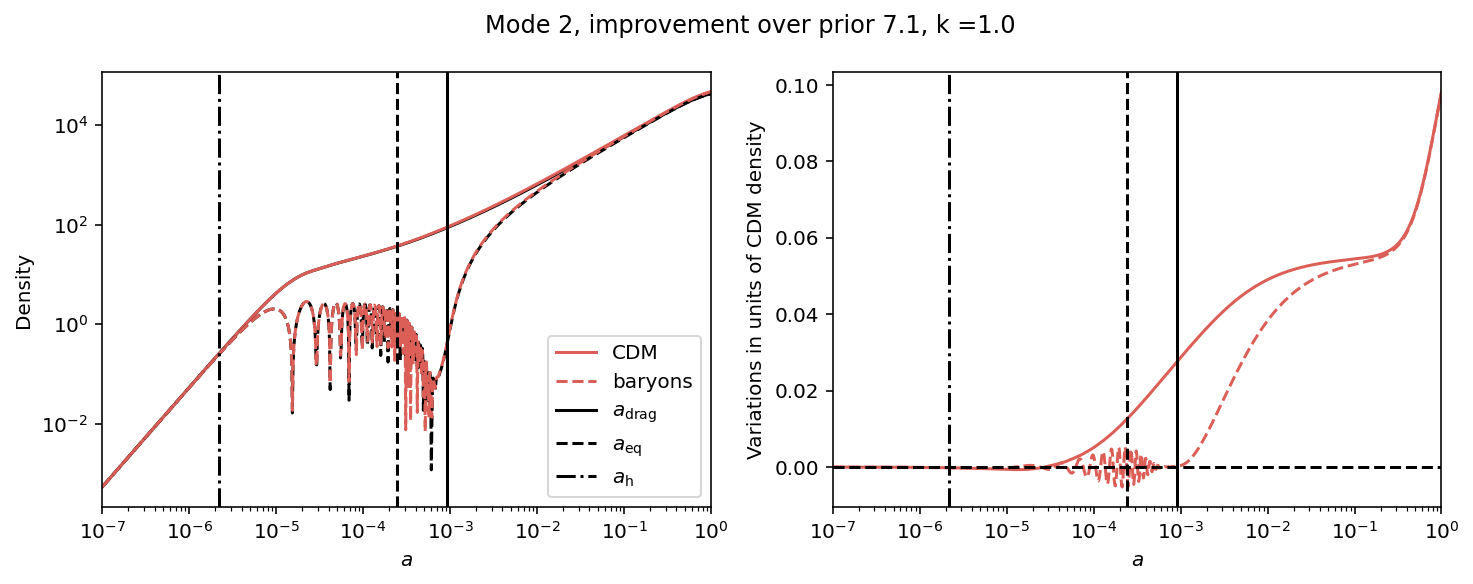

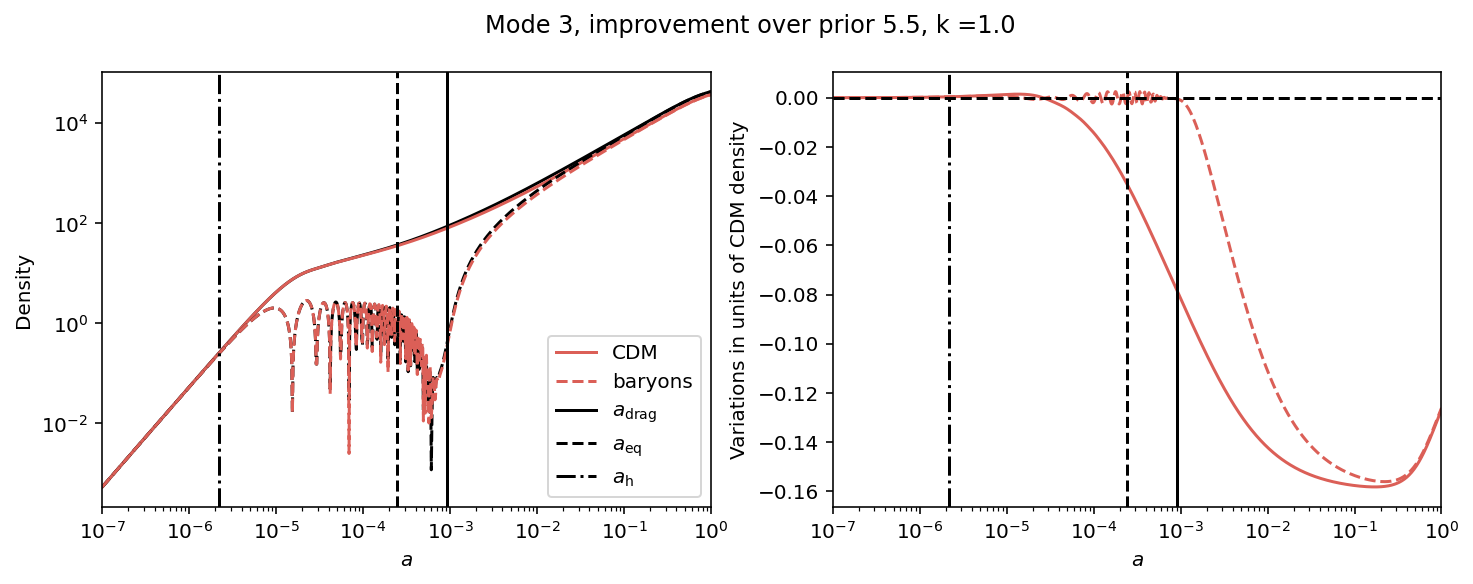

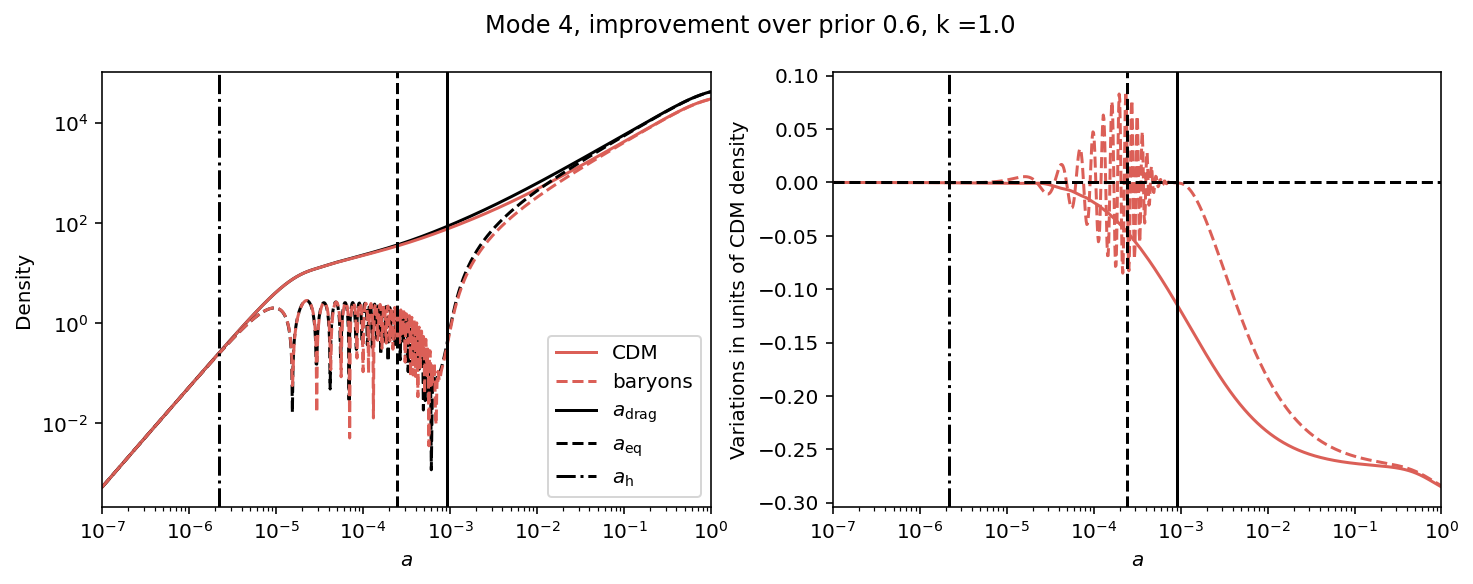

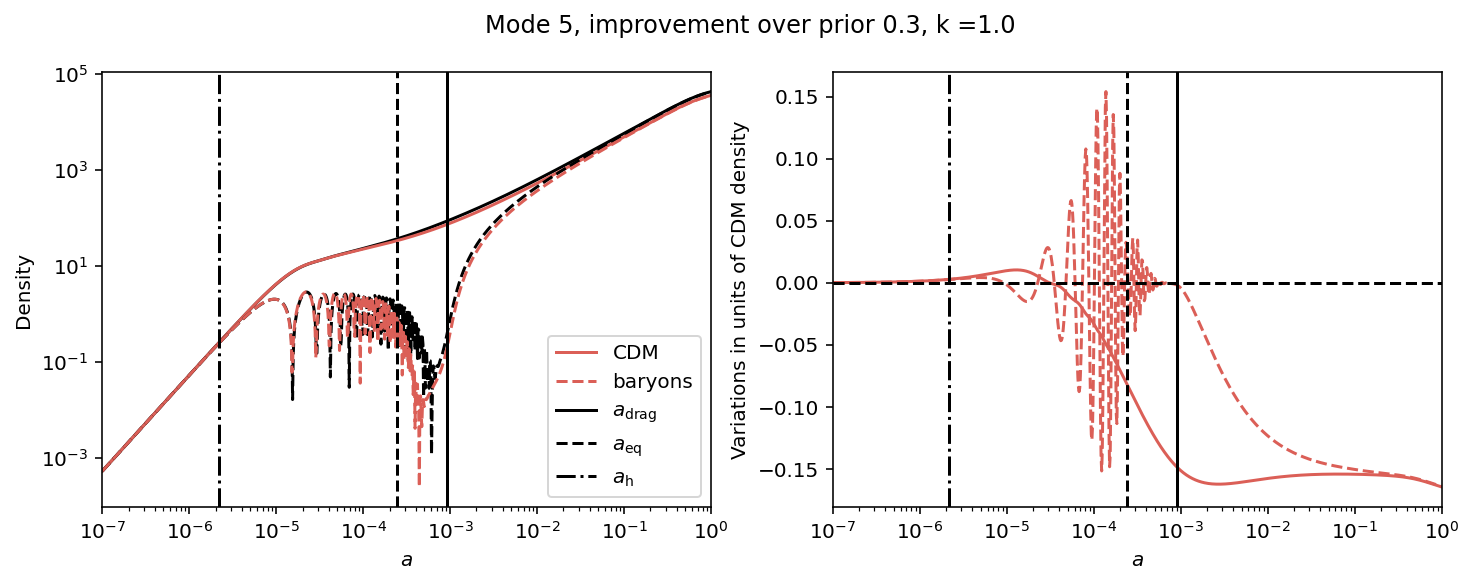

In [19]:
# now do parameter variations along the KL modes of the posterior with respect to the prior:
for ind in range(len(param_names)):
    # do a 2 sigma variation to see effects in the plots:
    camb_pars_plus = camb_helper(chain, np.exp(mean_params +2.*param_directions[:,ind]))
    camb_pars_minus = camb_helper(chain, np.exp(mean_params -2.*param_directions[:,ind]))
    # compute camb power spectra:
    results_plus = camb.get_results(camb_pars_plus)
    results_minus = camb.get_results(camb_pars_minus)
    # compute perturbation evolution:
    plus_ev = results_plus.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])
    minus_ev = results_minus.get_redshift_evolution(k, z,['delta_cdm','delta_baryon','H'])
    # plot:
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle('Mode '+str(ind+1)+', improvement over prior '+str(round(np.sqrt(KL_eig[ind]-1),1))+', k ='+str(k[0]))
    ax[0].plot(a, np.abs(mean_ev[0,:,0]), color='k')
    ax[0].plot(a, np.abs(plus_ev[0,:,0]), color=sns.hls_palette(6)[0], label='CDM')
    ax[0].plot(a, np.abs(mean_ev[0,:,1]), ls='--', color='k')
    ax[0].plot(a, np.abs(plus_ev[0,:,1]), ls='--', color=sns.hls_palette(6)[0], label='baryons')
    #ax[0].plot(a, np.abs(minus_ev[0,:,0]), color=sns.hls_palette(6)[2])
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Density')
    ax[1].plot(a, (plus_ev[0,:,0]-mean_ev[0,:,0])/mean_ev[0,:,0], color=sns.hls_palette(6)[0])
    #ax[1].plot(a, (minus_ev[0,:,0]-mean_ev[0,:,0])/mean_ev[0,:,0], color=sns.hls_palette(6)[2])
    ax[1].plot(a, (plus_ev[0,:,1]-mean_ev[0,:,1])/mean_ev[0,:,0], ls='--', color=sns.hls_palette(6)[0])
    #ax[1].plot(a, (minus_ev[0,:,1]-mean_ev[0,:,1])/mean_ev[0,:,0], ls='--', color=sns.hls_palette(6)[2])
    ax[1].axhline(0., ls='--', color='k')
    ax[1].set_ylabel('Variations in units of CDM density')
    # vertical lines with relevant times:
    for _ax in ax:
        _ax.axvline(1./(1.+mean_results.get_derived_params()['zdrag']), ls='-', color='k', label='$a_{\\rm drag}$')
        _ax.axvline(1./(1.+mean_results.get_derived_params()['zeq']), ls='--', color='k', label='$a_{\\rm eq}$')
        _ax.axvline(a[np.argmin(np.abs(mean_ev[0,:,2]-k[0]))], ls='-.', color='k', label='$a_{\\rm h}$')       
        #_ax.axvline(1./(1.+results_plus.get_derived_params()['zdrag']), ls='-', color=sns.hls_palette(6)[0], label='$a_{\\rm drag}$')
        #_ax.axvline(1./(1.+results_plus.get_derived_params()['zeq']), ls='--', color=sns.hls_palette(6)[0], label='$a_{\\rm eq}$')
    for _ax in ax:
        _ax.set_xlabel('$a$')
        _ax.set_xscale('log')
        _ax.set_xlim([np.amin(a), np.amax(a)])
    #   
    ax[0].legend()       

As we can see the first two modes are dominated by the effect of changing $\Omega_m$ (that can also be easily seen by the corresponding decrease in $\Omega_\Lambda$ giving the growth enhancement at late times).
The third mode on the other hand is happening at mostly constant $\Omega_m$ (since there is no late time feature) and clearly shows the effect of CDM suppression/enhancement obtained by increasing/decreasing baryon density at fixed total matter density (see for example Sec. 5 of https://arxiv.org/pdf/astro-ph/9510117.pdf).
Notice that density perturbations are in units of primordial comoving curvature so we do not see the effect of changing the power spectrum parameters. 

# Prior removal:

We know parameters have projection effects due to prior constrained volume being marginalized over.
Here we (linearly) undo that to get rid of prior effects.

There are two ways of getting rid of the prior. The first one is fix totally prior constrained directions.
This results in the best-fitting subspaces described in (https://arxiv.org/pdf/1902.01366.pdf).
The error on parameters can get smaller in this case since we are zeroing prior volume.

To do so we take each sample, remove the prior mean, transform it to KL space, then go back to parameter space truncating modes, leaving out the least constrained ones and the add back the prior mean.

In [22]:
idx = [chain.index[name] for name in KL_param_names]
prior_mean = prior_chain.getMeans(pars=[prior_chain.index[name] for name in KL_param_names])
inv_KL_eigv = np.linalg.inv(KL_eigv)
inv_KL_eigv[3:,:]=0
KL_filtered_samples = np.dot(np.dot(chain.samples[:,idx]-prior_mean, KL_eigv), inv_KL_eigv)+prior_mean
KL_filtered_samples = np.exp(KL_filtered_samples)

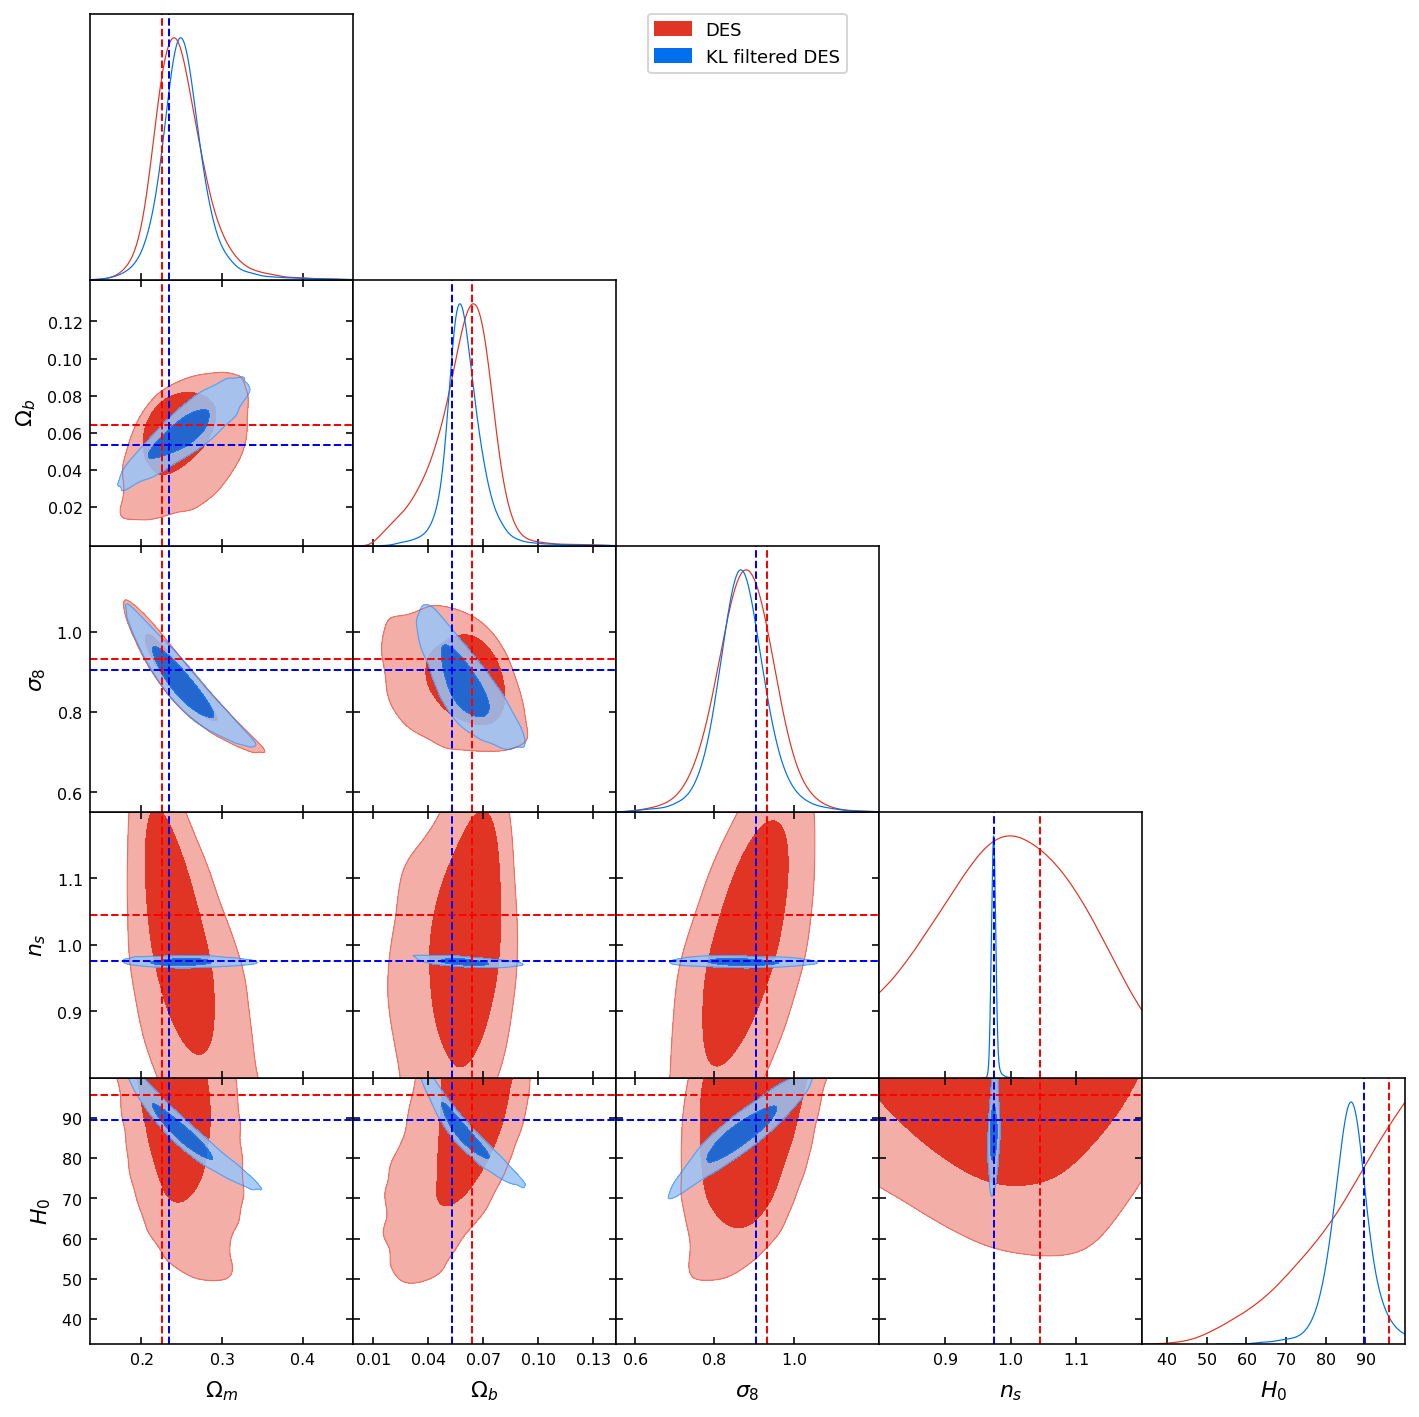

In [23]:
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=chain.loglikes, 
                     weights=chain.weights, 
                     names=param_names, 
                     labels=[ name.label for name in chain.getParamNames().parsWithNames(param_names)], 
                     label='KL filtered DES',
                     settings=settings)
g = plots.get_subplot_plotter()
g.triangle_plot([chain, KL_chain], params=param_names, filled=True)
bestfit_chain = [par.bestfit_sample for par in chain.getMargeStats().parsWithNames(param_names)]
bestfit_chain_kl = [par.bestfit_sample for par in KL_chain.getMargeStats().parsWithNames(param_names)]
for i in range(len(param_names)):
    _ax = g.subplots[i,i]
    _ax.axvline(bestfit_chain[i], ls='--', lw=1., color='red')
    _ax.axvline(bestfit_chain_kl[i], ls='--', lw=1., color='blue')
for i in range(len(param_names)):
    for j in range(len(param_names)):
        if i>j:
            _ax = g.subplots[i,j]
            _ax.axhline(bestfit_chain[i], ls='--', lw=1., color='red')
            _ax.axhline(bestfit_chain_kl[i], ls='--', lw=1., color='blue')
            _ax.axvline(bestfit_chain[j], ls='--', lw=1., color='red')
            _ax.axvline(bestfit_chain_kl[j], ls='--', lw=1., color='blue')

As we can see constraints are tighter since we have fixed prior constrained directions.

The best fit is closer to the peak since the postrior looks increasingly Gaussian as we remove parameters.

Some contours do not change, which is good, some others do because they were influenced by the prior.

This is a-posteriori dimensional reduction, the difference with a-priori dimensional reduction is that this happens around the mean of the posterior and not the prior. Non linearities between the two points (rotations) can alter the local structure of the posterior. Hence a-priori dimensional reduction can introduce biases while doing that a-posteriori does not.

The second way of getting rid of the prior is to send it to infinity. This is far more challenging because it is more subject to non-Gaussianities. To mitigate this we do not undo the prior on data constrained directions but only on prior constrained ones.

In [24]:
idx = [chain.index[name] for name in KL_param_names]
prior_mean = prior_chain.getMeans(pars=[prior_chain.index[name] for name in KL_param_names])
inv_KL_eigv = np.linalg.inv(KL_eigv)
KL_eig_inv = 1./KL_eig
KL_eig_inv[:3] = 0
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv)), np.dot(KL_eigv.T, (chain.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv)*KL_eig_inv), np.dot(KL_eigv.T, prior_mean)), inv_KL_eigv)
KL_filtered_samples = np.exp(KL_filtered_samples)

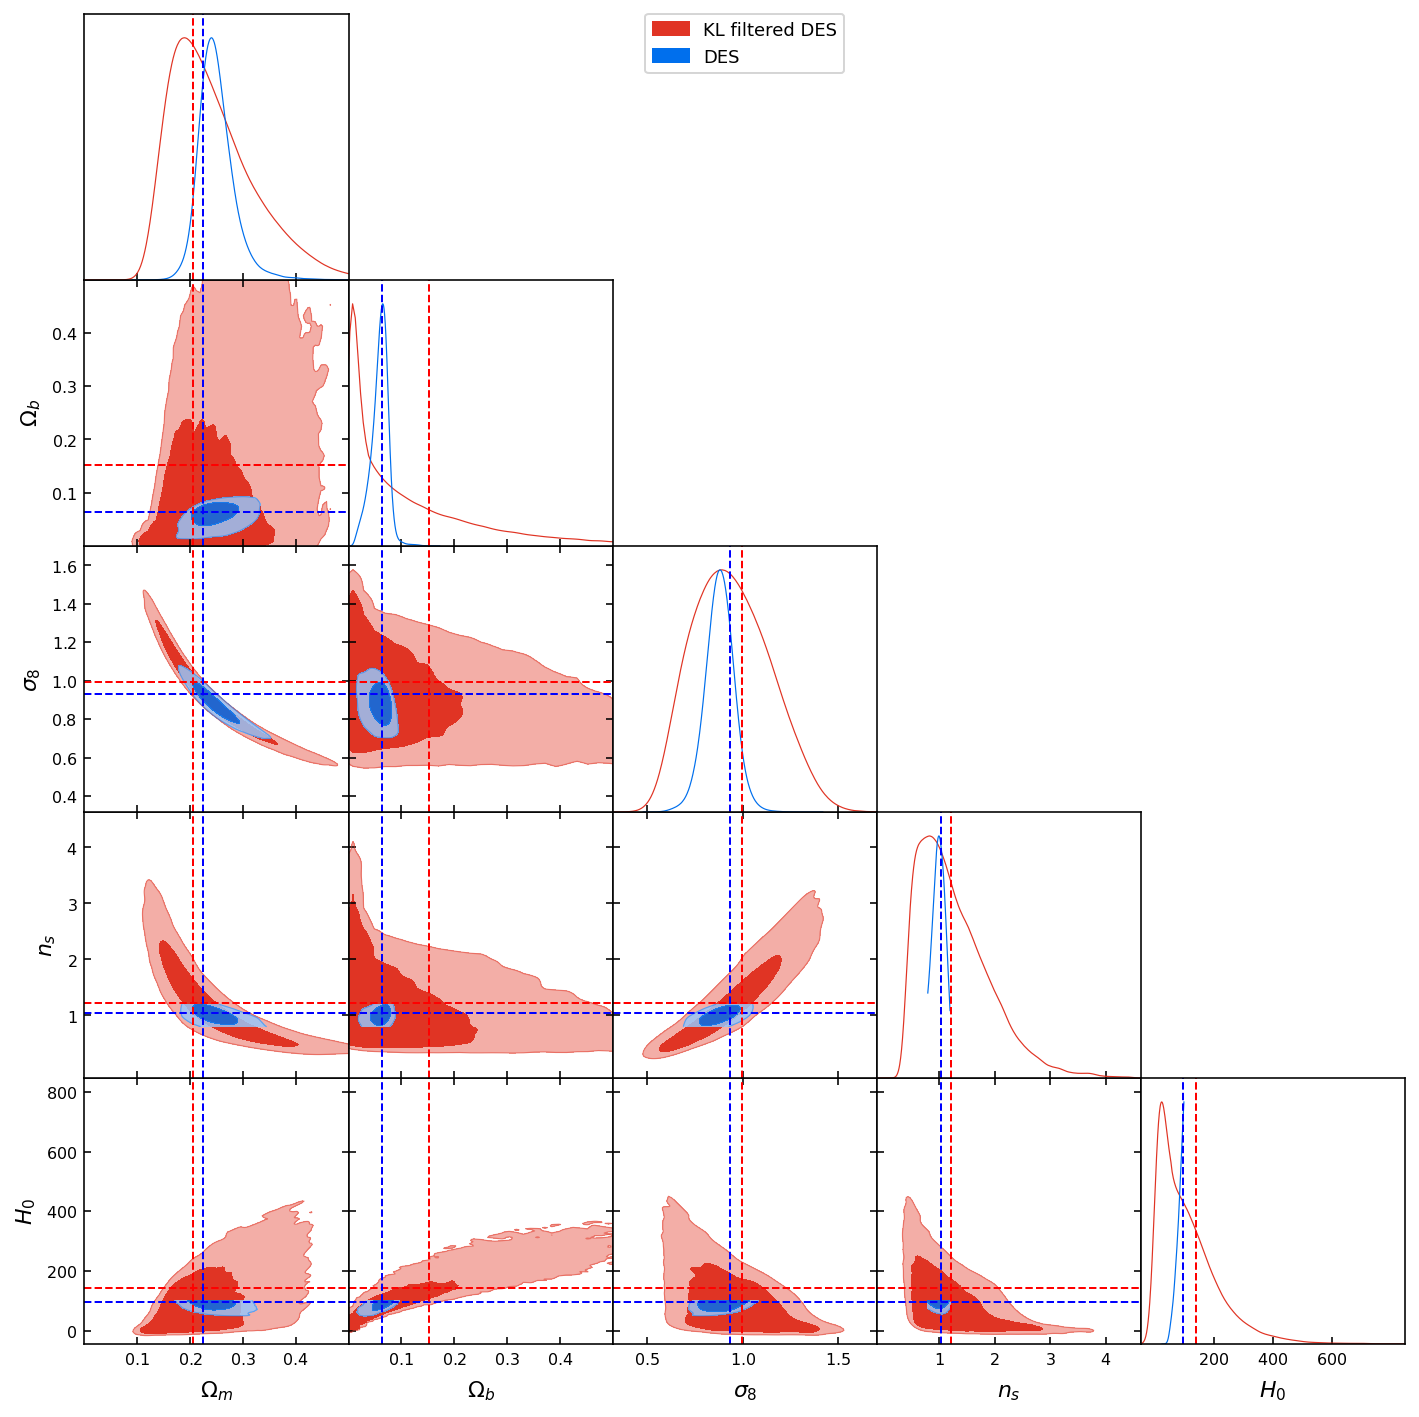

In [25]:
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=chain.loglikes, 
                     weights=chain.weights, 
                     names=param_names, 
                     labels=[ name.label for name in chain.getParamNames().parsWithNames(param_names)], 
                     label='KL filtered DES',
                     settings=settings)
g = plots.get_subplot_plotter()
param_limits = {'omegam':[0.,.5], 'omegab':[0.,.5]}
g.triangle_plot([KL_chain, chain], params=param_names, filled=True, param_limits=param_limits)
bestfit_chain = [par.bestfit_sample for par in chain.getMargeStats().parsWithNames(param_names)]
bestfit_chain_kl = [par.bestfit_sample for par in KL_chain.getMargeStats().parsWithNames(param_names)]
for i in range(len(param_names)):
    _ax = g.subplots[i,i]
    _ax.axvline(bestfit_chain[i], ls='--', lw=1., color='blue')
    _ax.axvline(bestfit_chain_kl[i], ls='--', lw=1., color='red')
for i in range(len(param_names)):
    for j in range(len(param_names)):
        if i>j:
            _ax = g.subplots[i,j]
            _ax.axhline(bestfit_chain[i], ls='--', lw=1., color='blue')
            _ax.axhline(bestfit_chain_kl[i], ls='--', lw=1., color='red')
            _ax.axvline(bestfit_chain[j], ls='--', lw=1., color='blue')
            _ax.axvline(bestfit_chain_kl[j], ls='--', lw=1., color='red')